In [1]:
# Hücre 1: Gerekli Kütüphaneler ve Genel Ayarlar
# Bu hücrede tüm gerekli kütüphaneler import edilir ve genel uyarı ayarları yapılır.
# Bu hücreyi her zaman ilk çalıştırmalısınız.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif # f_classif, sınıflandırma görevleri için ANOVA F-değerini kullanır.
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree # Karar Ağacı görselleştirmesi için eklendi
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, ConfusionMatrixDisplay # ConfusionMatrixDisplay eklendi
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA # Yeni eklendi: Boyut indirgeme için
# from sklearn.manifold import TSNE # İsteğe bağlı: Daha gelişmiş boyut indirgeme için (büyük veri setlerinde yavaş olabilir)
import warnings
import time # İşlem sürelerini ölçmek için eklendi
from tabulate import tabulate # Tabloları daha düzenli göstermek için eklendi
from collections import Counter # Hücre 6'da kullanılan Counter sınıfı için eklendi

# Uyarıları görmezden gelmek için (isteğe bağlı, ancak bazen sklearn uyarıları çok olabilir)
warnings.filterwarnings('ignore')

print("Gerekli kütüphaneler başarıyla yüklendi.")



Gerekli kütüphaneler başarıyla yüklendi.


Veri başarıyla yüklendi ve 100.000 örnek seçildi.
Sütun isimleri atandı.

Veri setinin boyutu: (100000, 29)

Veri setinin ilk 5 satırı:
|    |   Label |       f0 |        f1 |          f2 |       f3 |         f4 |       f5 |         f6 |        f7 |      f8 |       f9 |      f10 |       f11 |     f12 |      f13 |       f14 |       f15 |     f16 |      f17 |       f18 |        f19 |     f20 |      f21 |      f22 |      f23 |      f24 |      f25 |      f26 |      f27 |
|----|---------|----------|-----------|-------------|----------|------------|----------|------------|-----------|---------|----------|----------|-----------|---------|----------|-----------|-----------|---------|----------|-----------|------------|---------|----------|----------|----------|----------|----------|----------|----------|
|  0 |       0 | 1.13868  | -0.726635 | -0.00578982 | 0.204118 |  0.153842  | 1.5859   | -0.045576  | -1.44853  | 1.08654 | 1.59847  | 0.399295 |  0.128065 | 2.21487 | 1.20669  |  0.138531 |  

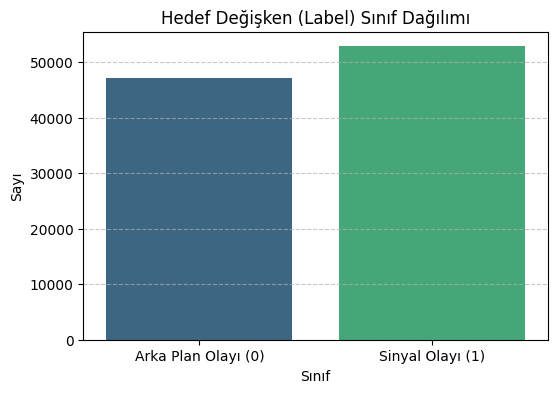


--- Özelliklerin Dağılımını Görselleştirme (Kutu Grafikleri) ---


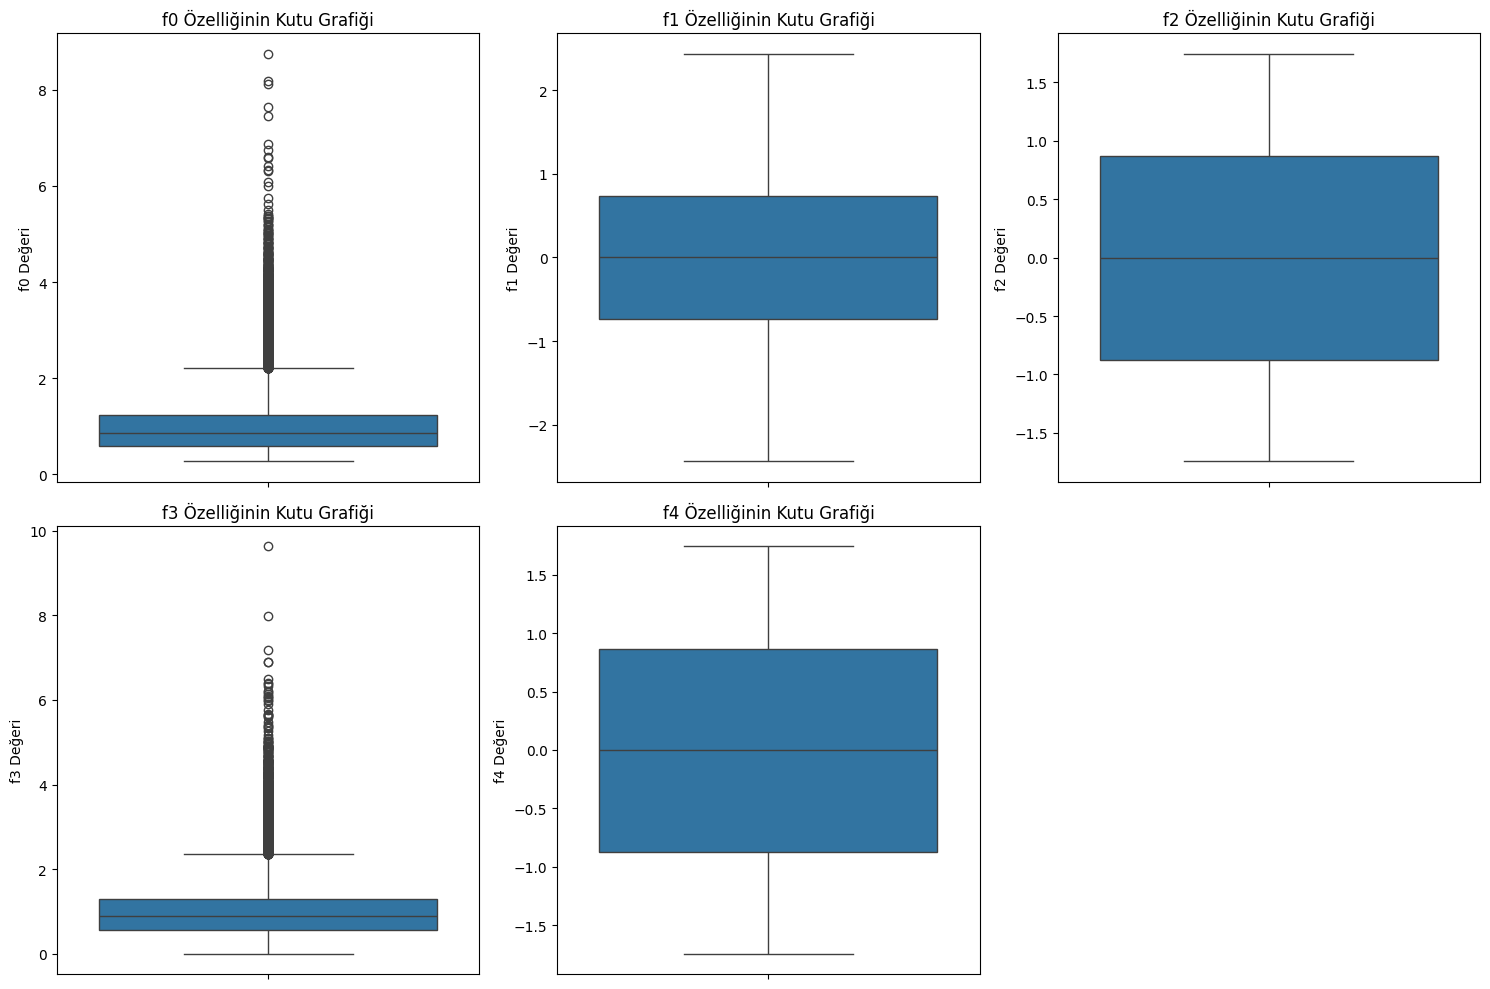


--- Özelliklerin Dağılımını Görselleştirme (Histogramlar) ---


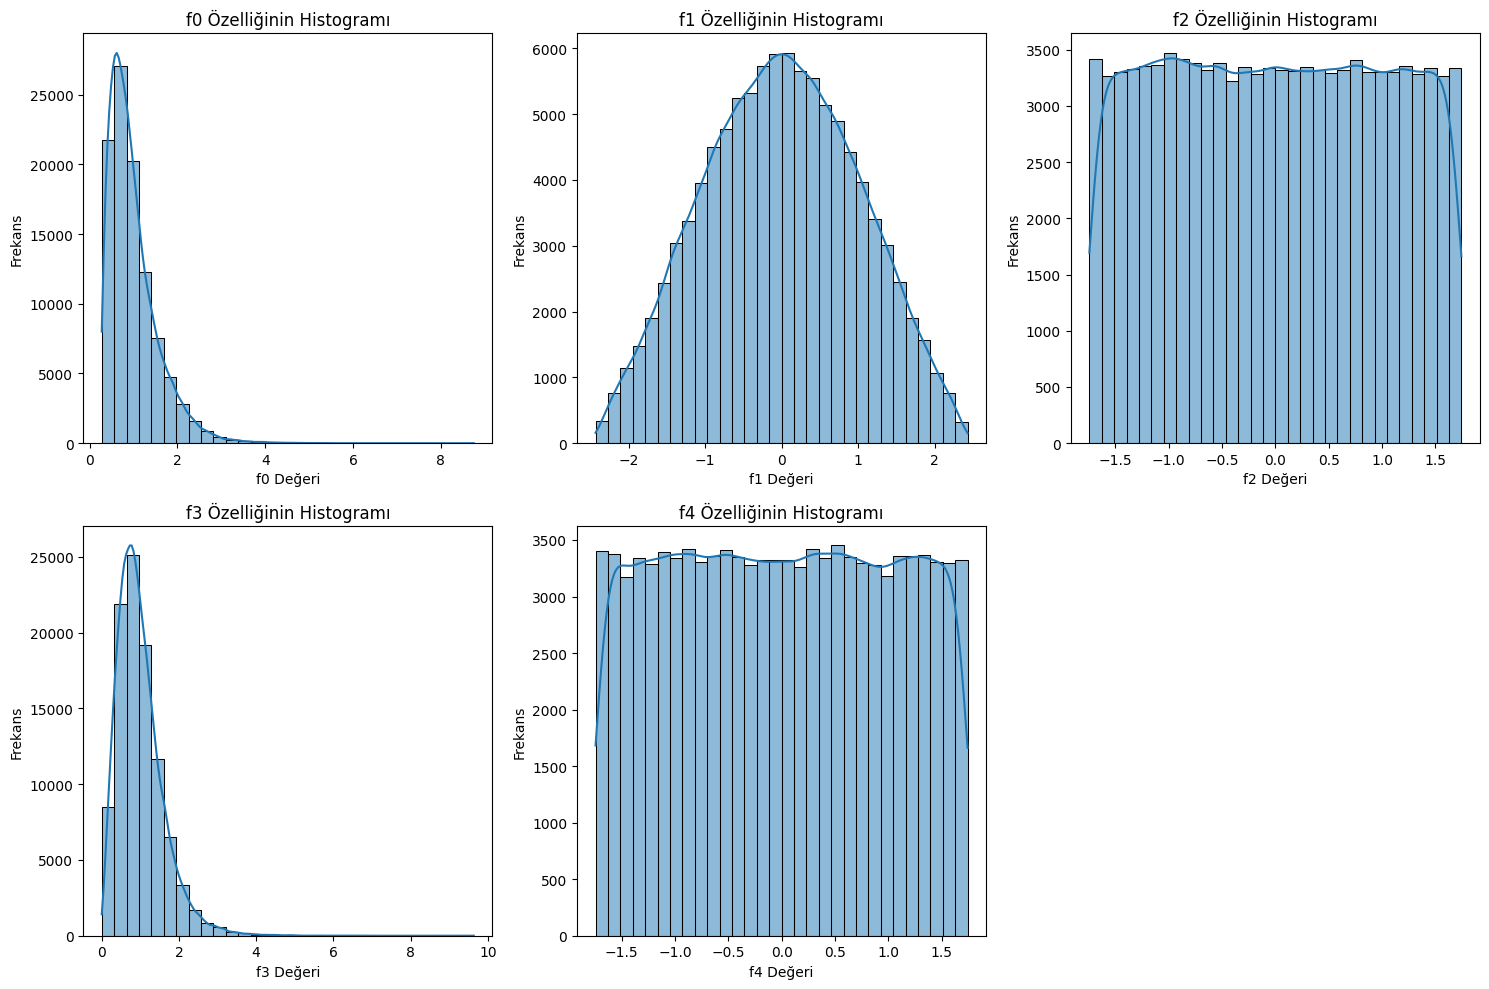

--------------------------------------------------


In [2]:
# Hücre 2: Veri Yükleme ve İlk İnceleme
# Bu hücrede HIGGS veri seti yüklenir, örnekleme yapılır ve temel istatistiksel bilgiler görüntülenir.
# Hata alırsanız, DATA_PATH'i kontrol etmelisiniz.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate # Bu satır eklendi: tabulate kütüphanesini import eder

# Dosya yolu
# Veri setinin Jupyter Notebook dosyanızla aynı dizinde olduğunu varsayıyorum.
# Eğer farklı bir konumdaysa, lütfen bu yolu güncelleyin.
DATA_PATH = "../data/HIGGS.csv.gz" # Projenizin kök dizininde 'data' klasörü altında olduğunu varsayıyorum

# 1.a) CSV'yi oku ve 100k örnek al
# HIGGS dataset'i başlık satırı içermediği için header=None kullanıyoruz.
# İlk sütun 'Label', diğerleri özellikler.
try:
    # Büyük veri setlerinde belleği yönetmek için chunksize kullanmak faydalı olabilir,
    # ancak 100k örnek için doğrudan okuma ve örnekleme de uygundur.
    # Daha büyük veri setleri için (örn. 11 milyon) chunksize veya dask gibi kütüphaneler düşünülebilir.
    df = pd.read_csv(DATA_PATH, compression='gzip', header=None)
    
    # Hızlı test ve bellek yönetimi için örneklem sayısını azaltabilirsiniz (örn. n=10_000)
    # Ancak ödevde 100.000 örnek istendiği için bu değeri kullanıyoruz.
    df = df.sample(n=100_000, random_state=42).reset_index(drop=True)
    print("Veri başarıyla yüklendi ve 100.000 örnek seçildi.")
except FileNotFoundError:
    print(f"Hata: '{DATA_PATH}' bulunamadı. Lütfen dosya yolunu kontrol edin.")
    print("Örnek bir DataFrame oluşturuluyor (dosya bulunamadığı için).")
    # Eğer dosya bulunamazsa, örnek bir DataFrame oluşturarak kodun geri kalanının çalışmasını sağlayabiliriz.
    # Ancak gerçek proje için doğru dosya yolunu sağlamak önemlidir.
    num_samples = 100_000
    num_features = 28
    # Rastgele veri ile bir DataFrame oluştur
    df = pd.DataFrame(np.random.rand(num_samples, num_features + 1))
    # İlk sütunu 'Label' olarak rastgele 0 veya 1 ata
    df[0] = np.random.randint(0, 2, num_samples)
    
# 1.b) Sütun isimleri
# İlk sütun 'Label', diğerleri 'f0'dan 'f27'ye kadar özellikler.
cols = ["Label"] + [f"f{i}" for i in range(28)]
df.columns = cols
print("Sütun isimleri atandı.")

# Veri setinin boyutunu göster
print(f"\nVeri setinin boyutu: {df.shape}")

# Veri setinin ilk 5 satırını göster
print("\nVeri setinin ilk 5 satırı:")
print(tabulate(df.head(), headers='keys', tablefmt='github'))

# Veri setinin temel istatistiksel özetini göster
print("\nVeri setinin temel istatistiksel özeti:")
print(tabulate(df.describe().T, headers='keys', tablefmt='github'))

# Sınıf dağılımını göster (Hedef değişken 'Label')
print("\n'Label' sütununun sınıf dağılımı:")
label_counts = df["Label"].value_counts().reset_index()
label_counts.columns = ['Label', 'Count']
print(tabulate(label_counts, headers='keys', tablefmt='github', showindex=False))

# Label sütununun dağılımını görselleştirme (Çubuk Grafiği)
plt.figure(figsize=(6, 4))
sns.countplot(x='Label', data=df, palette='viridis')
plt.title('Hedef Değişken (Label) Sınıf Dağılımı')
plt.xlabel('Sınıf')
plt.ylabel('Sayı')
plt.xticks(ticks=[0, 1], labels=['Arka Plan Olayı (0)', 'Sinyal Olayı (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n--- Özelliklerin Dağılımını Görselleştirme (Kutu Grafikleri) ---")
# İlk 5 özelliğin dağılımını kutu grafikleri ile görselleştirme
# Bu, aykırı değerleri ve veri dağılımını anlamak için faydalıdır.
num_features_to_plot = 5
plt.figure(figsize=(15, 10))
for i, col in enumerate(cols[1:num_features_to_plot + 1]): # 'Label' hariç ilk 5 özellik
    plt.subplot(2, (num_features_to_plot + 1) // 2, i + 1) # Dinamik subplot düzeni
    sns.boxplot(y=df[col])
    plt.title(f'{col} Özelliğinin Kutu Grafiği')
    plt.ylabel(f'{col} Değeri')
plt.tight_layout()
plt.show()

print("\n--- Özelliklerin Dağılımını Görselleştirme (Histogramlar) ---")
# İlk 5 özelliğin dağılımını histogramlar ile görselleştirme
# Bu, verinin şeklini ve yoğunluğunu anlamak için faydalıdır.
plt.figure(figsize=(15, 10))
for i, col in enumerate(cols[1:num_features_to_plot + 1]): # 'Label' hariç ilk 5 özellik
    plt.subplot(2, (num_features_to_plot + 1) // 2, i + 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'{col} Özelliğinin Histogramı')
    plt.xlabel(f'{col} Değeri')
    plt.ylabel('Frekans')
plt.tight_layout()
plt.show()

print("-" * 50)


In [4]:
# Hücre 2.5: Veri Kümeleme Görselleştirmesi (PCA ile)
# Bu hücre, yüksek boyutlu veri setini Temel Bileşenler Analizi (PCA) kullanarak 2 boyuta indirger.
# Ardından, bu iki ana bileşeni kullanarak veri noktalarını sınıf etiketlerine göre renklendirerek
# bir dağılım grafiği çizer. Bu, verilerdeki doğal ayrılabilirliği ve kümeleri görsel olarak anlamanıza yardımcı olur.

print("\n--- Veri Kümeleme Görselleştirmesi (PCA ile) ---")

# PCA uygulamak için özellik verisini (X) ve hedef değişkeni (y) kullanacağız.
# X ve y'nin Hücre 4'te tanımlanmış olması gerekmektedir.
# Eğer bu hücreyi tek başına çalıştırıyorsanız, X ve y'yi manuel olarak tanımlamanız gerekebilir.
try:
    # PCA'yı uygulamadan önce veriyi ölçeklendirmek iyi bir uygulamadır.
    # Hücre 4'te StandardScaler ile ölçeklendirilmiş X_scaled_standard_df kullanabiliriz.
    # Ancak burada genel bir örnek olması adına, X üzerinde StandardScaler uygulayalım.
    temp_scaler = StandardScaler()
    X_scaled_for_pca = temp_scaler.fit_transform(X)

    pca = PCA(n_components=2) # Veriyi 2 boyuta indirge
    principal_components = pca.fit_transform(X_scaled_for_pca)

    # İndirgenmiş boyutları bir DataFrame'e dönüştür
    pca_df = pd.DataFrame(data=principal_components, columns=['Principal Component 1', 'Principal Component 2'])
    pca_df['Label'] = y.values # Hedef değişkeni ekle

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x='Principal Component 1',
        y='Principal Component 2',
        hue='Label', # Sınıf etiketlerine göre renklendir
        palette='viridis',
        data=pca_df,
        alpha=0.6, # Noktaların şeffaflığı
        s=10 # Nokta boyutu
    )
    plt.title('Veri Kümeleme Görselleştirmesi (PCA ile 2 Boyut)')
    plt.xlabel(f'Temel Bileşen 1 (Açıklanan Varyans: {pca.explained_variance_ratio_[0]*100:.2f}%)')
    plt.ylabel(f'Temel Bileşen 2 (Açıklanan Varyans: {pca.explained_variance_ratio_[1]*100:.2f}%)')
    plt.legend(title='Sınıf', loc='best', labels=['Arka Plan (0)', 'Sinyal (1)'])
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

    print(f"PCA ile açıklanan toplam varyans: {pca.explained_variance_ratio_.sum()*100:.2f}%")

except NameError:
    print("Hata: X veya y değişkenleri tanımlı değil. Lütfen önceki hücreleri (Hücre 2 ve 4) çalıştırdığınızdan emin olun.")
except Exception as e:
    print(f"Veri kümeleme görselleştirmesi sırasında bir hata oluştu: {e}")

print("-" * 50)



--- Veri Kümeleme Görselleştirmesi (PCA ile) ---
Hata: X veya y değişkenleri tanımlı değil. Lütfen önceki hücreleri (Hücre 2 ve 4) çalıştırdığınızdan emin olun.
--------------------------------------------------



IQR metodu ile aykırı değer tespiti ve 1.5 katsayısı kullanılarak NaN ile değiştirme:
  - 'f0' sütununda 3815 adet aykırı değer tespit edildi ve NaN yapıldı.
  - 'f3' sütununda 2989 adet aykırı değer tespit edildi ve NaN yapıldı.
  - 'f5' sütununda 4991 adet aykırı değer tespit edildi ve NaN yapıldı.
  - 'f6' sütununda 686 adet aykırı değer tespit edildi ve NaN yapıldı.
  - 'f9' sütununda 3967 adet aykırı değer tespit edildi ve NaN yapıldı.
  - 'f10' sütununda 407 adet aykırı değer tespit edildi ve NaN yapıldı.
  - 'f13' sütununda 3204 adet aykırı değer tespit edildi ve NaN yapıldı.
  - 'f17' sütununda 3257 adet aykırı değer tespit edildi ve NaN yapıldı.
  - 'f21' sütununda 13987 adet aykırı değer tespit edildi ve NaN yapıldı.
  - 'f22' sütununda 7357 adet aykırı değer tespit edildi ve NaN yapıldı.
  - 'f23' sütununda 19811 adet aykırı değer tespit edildi ve NaN yapıldı.
  - 'f24' sütununda 5037 adet aykırı değer tespit edildi ve NaN yapıldı.
  - 'f25' sütununda 6004 adet aykırı değer

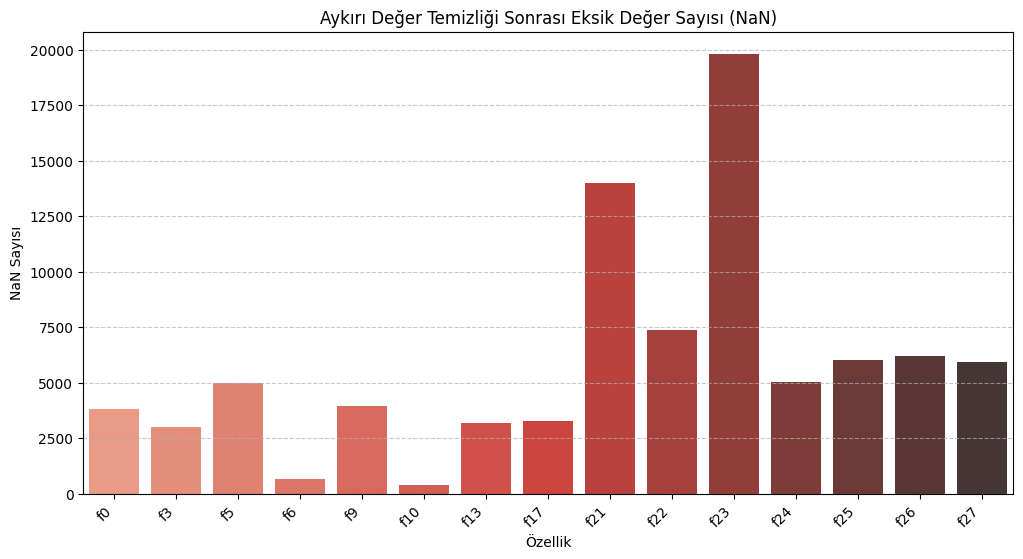


--- Aykırı Değer İşleme Öncesi ve Sonrası Kutu Grafikleri Karşılaştırması (İlk 5 Özellik) ---


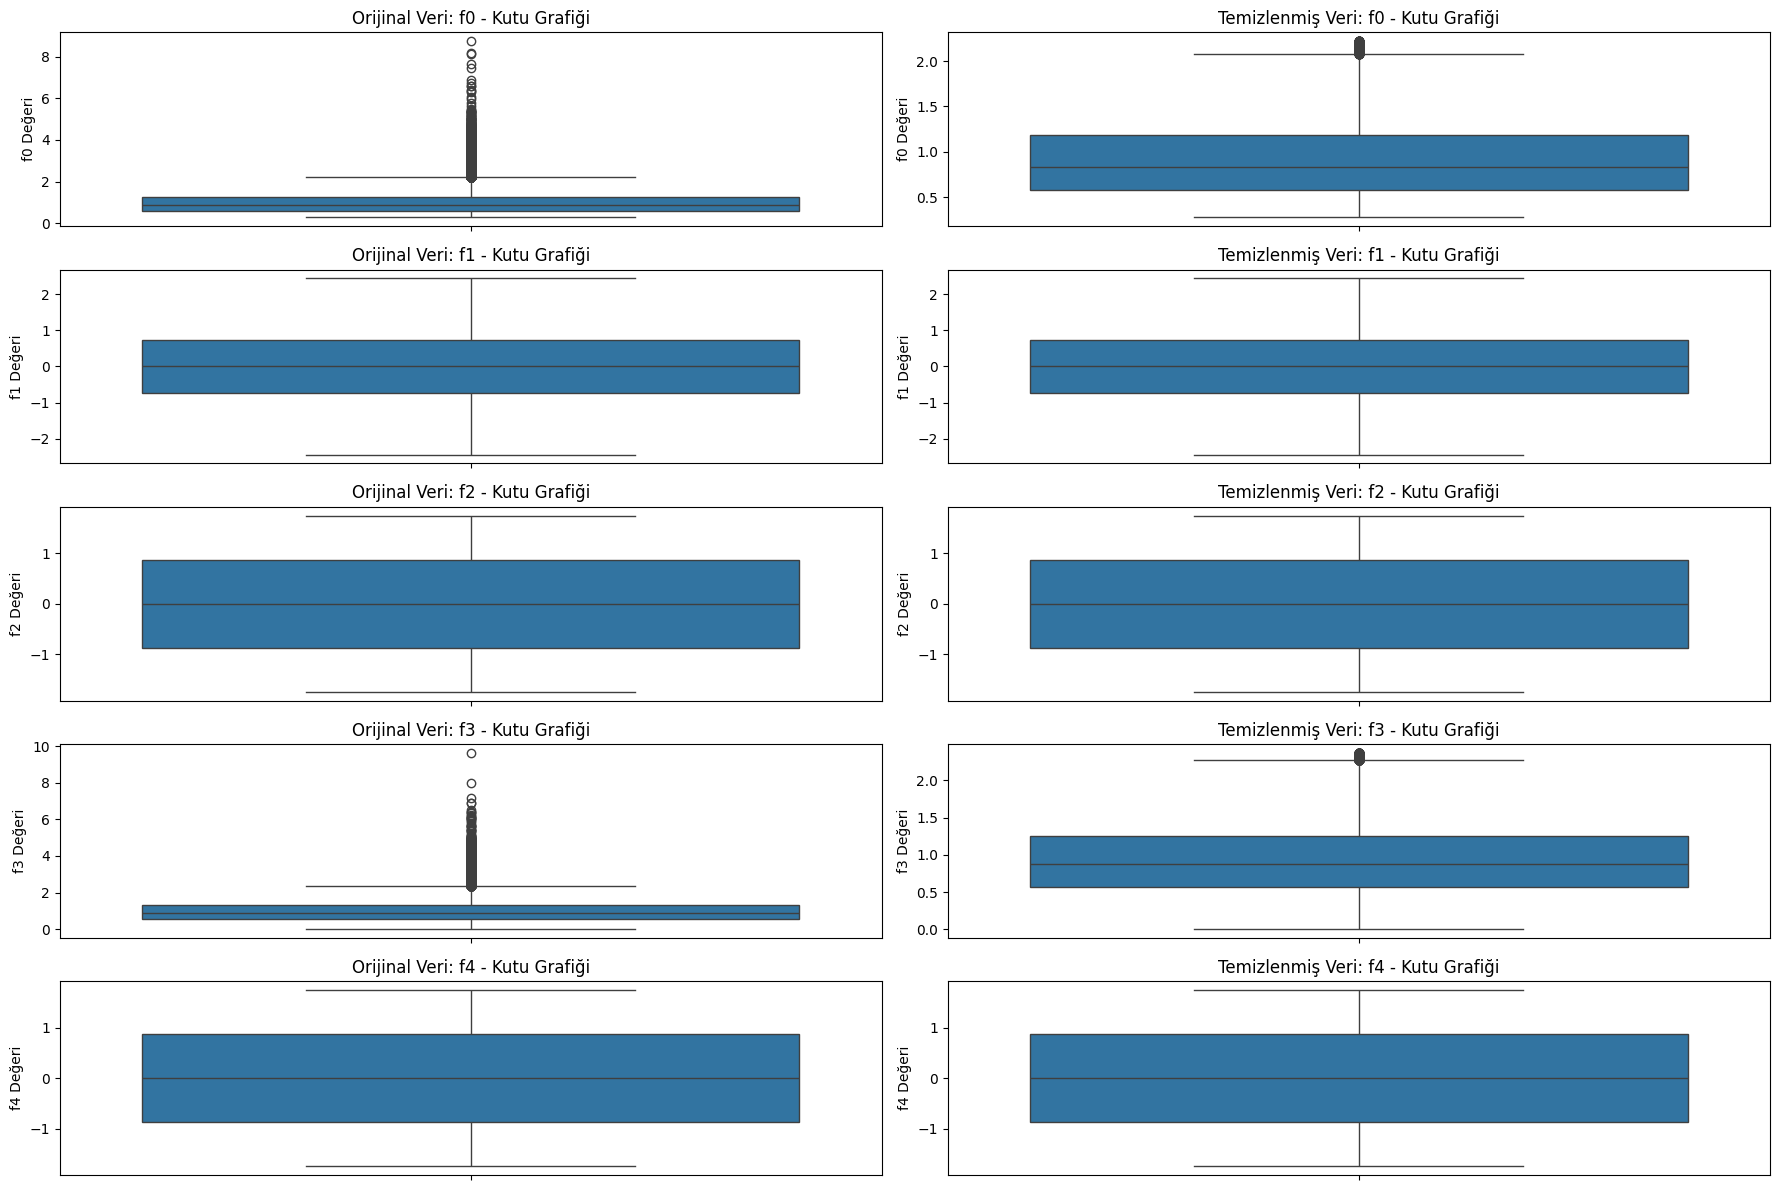

--------------------------------------------------


In [5]:
# Hücre 3: Aykırı Değer (Outlier) ve Eksik Değer (Missing Value) Kontrolü
# Bu hücrede, veri setindeki aykırı değerler IQR metodu kullanılarak tespit edilir ve NaN olarak işaretlenir.
# Ardından, eksik değerlerin (hem orijinal hem de aykırı değerlerden kaynaklanan NaN'lar) nasıl işleneceği belirlenir.

# Aykırı değer tespiti ve işlenmesi için fonksiyon
def handle_outliers_iqr(df, column, factor=1.5):
    """
    IQR metodu kullanarak bir sütundaki aykırı değerleri tespit eder ve NaN ile değiştirir.
    
    Args:
        df (pd.DataFrame): İşlenecek DataFrame.
        column (str): Aykırı değerlerin aranacağı sütun adı.
        factor (float): IQR katsayısı (genellikle 1.5).
        
    Returns:
        pd.DataFrame: Aykırı değerleri NaN ile değiştirilmiş DataFrame.
        int: Tespit edilen aykırı değer sayısı.
    """
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Aykırı değer sınırları
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    # Aykırı değerleri tespit et
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    num_outliers = len(outliers)
    
    # Aykırı değerleri NaN ile değiştir
    df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), column] = np.nan
    
    return df, num_outliers

print("\nIQR metodu ile aykırı değer tespiti ve 1.5 katsayısı kullanılarak NaN ile değiştirme:")
# 'Label' sütunu hedef değişken olduğu için sadece özellik sütunlarında aykırı değer arıyoruz.
feature_cols = [col for col in df.columns if col != 'Label']
outlier_counts = {}

# Aykırı değer işleme öncesi kopyasını al
df_before_outlier_handling = df.copy()

for col in feature_cols:
    df, num_outliers = handle_outliers_iqr(df, col, factor=1.5)
    if num_outliers > 0:
        outlier_counts[col] = num_outliers
        print(f"  - '{col}' sütununda {num_outliers} adet aykırı değer tespit edildi ve NaN yapıldı.")

# Aykırı değer temizliği sonrası her sütundaki NaN değer sayısını göster
print("\nAykırı değer temizliği sonrası her sütundaki NaN değer sayısı:")
nan_counts_after_outliers = df.isnull().sum()
nan_df = nan_counts_after_outliers.reset_index()
nan_df.columns = ['Feature', 'NaN Count']
print(tabulate(nan_df, headers='keys', tablefmt='github', showindex=False))

# Eksik değerleri işleme stratejisi
# Bu adımda, NaN değerleri ortalama (mean) ile doldurma stratejisi uygulanmıştır.
# Alternatif olarak median, mode veya daha gelişmiş imputasyon yöntemleri kullanılabilir.
print("\nEksik değerler ortalama ile dolduruluyor...")
df_filled = df.fillna(df.mean(numeric_only=True))
print("Eksik değerler başarıyla dolduruldu.")

# Eksik değer doldurma sonrası NaN değer sayısını kontrol et
print("\nEksik değer doldurma sonrası her sütundaki NaN değer sayısı:")
nan_counts_after_fill = df_filled.isnull().sum()
nan_filled_df = nan_counts_after_fill.reset_index()
nan_filled_df.columns = ['Feature', 'NaN Count']
print(tabulate(nan_filled_df, headers='keys', tablefmt='github', showindex=False))

# --- Görselleştirmeler ---

# 1. Aykırı değer temizliği sonrası NaN değer sayısını görselleştirme (Çubuk Grafiği)
# Sadece NaN değeri olan sütunları göster
nan_counts_to_plot = nan_counts_after_outliers[nan_counts_after_outliers > 0]
if not nan_counts_to_plot.empty:
    plt.figure(figsize=(12, 6))
    sns.barplot(x=nan_counts_to_plot.index, y=nan_counts_to_plot.values, palette='Reds_d')
    plt.title('Aykırı Değer Temizliği Sonrası Eksik Değer Sayısı (NaN)')
    plt.xlabel('Özellik')
    plt.ylabel('NaN Sayısı')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("\nAykırı değer temizliği sonrası hiç NaN değeri bulunamadı, grafik çizilmedi.")

# 2. Aykırı değerlerin işlenmesi öncesi ve sonrası kutu grafikleri karşılaştırması
print("\n--- Aykırı Değer İşleme Öncesi ve Sonrası Kutu Grafikleri Karşılaştırması (İlk 5 Özellik) ---")
num_features_to_plot = 5
plt.figure(figsize=(18, 12)) # Daha büyük bir figür boyutu

for i, col in enumerate(feature_cols[:num_features_to_plot]):
    # Orijinal (aykırı değerler dahil)
    plt.subplot(num_features_to_plot, 2, 2*i + 1)
    sns.boxplot(y=df_before_outlier_handling[col])
    plt.title(f'Orijinal Veri: {col} - Kutu Grafiği')
    plt.ylabel(f'{col} Değeri')
    
    # Temizlenmiş (aykırı değerler NaN yapıldıktan sonra)
    plt.subplot(num_features_to_plot, 2, 2*i + 2)
    sns.boxplot(y=df[col].dropna()) # NaN değerleri çizimden çıkar
    plt.title(f'Temizlenmiş Veri: {col} - Kutu Grafiği')
    plt.ylabel(f'{col} Değeri')

plt.tight_layout()
plt.show()

print("-" * 50)


Eğitim seti boyutu: (80000, 28)
Test seti boyutu: (20000, 28)

StandardScaler ile ölçeklendirme tamamlandı.
StandardScaler ile ölçeklendirilmiş eğitim verisinin ilk 5 satırı:
|    |           f0 |         f1 |       f2 |        f3 |         f4 |           f5 |         f6 |       f7 |        f8 |          f9 |        f10 |        f11 |        f12 |       f13 |        f14 |        f15 |       f16 |       f17 |       f18 |       f19 |       f20 |          f21 |       f22 |          f23 |       f24 |       f25 |       f26 |         f27 |
|----|--------------|------------|----------|-----------|------------|--------------|------------|----------|-----------|-------------|------------|------------|------------|-----------|------------|------------|-----------|-----------|-----------|-----------|-----------|--------------|-----------|--------------|-----------|-----------|-----------|-------------|
|  0 | -0.000111901 | -0.16945   | 0.4788   | -0.760767 |  0.46046   |  1.08868     | -2.30526 

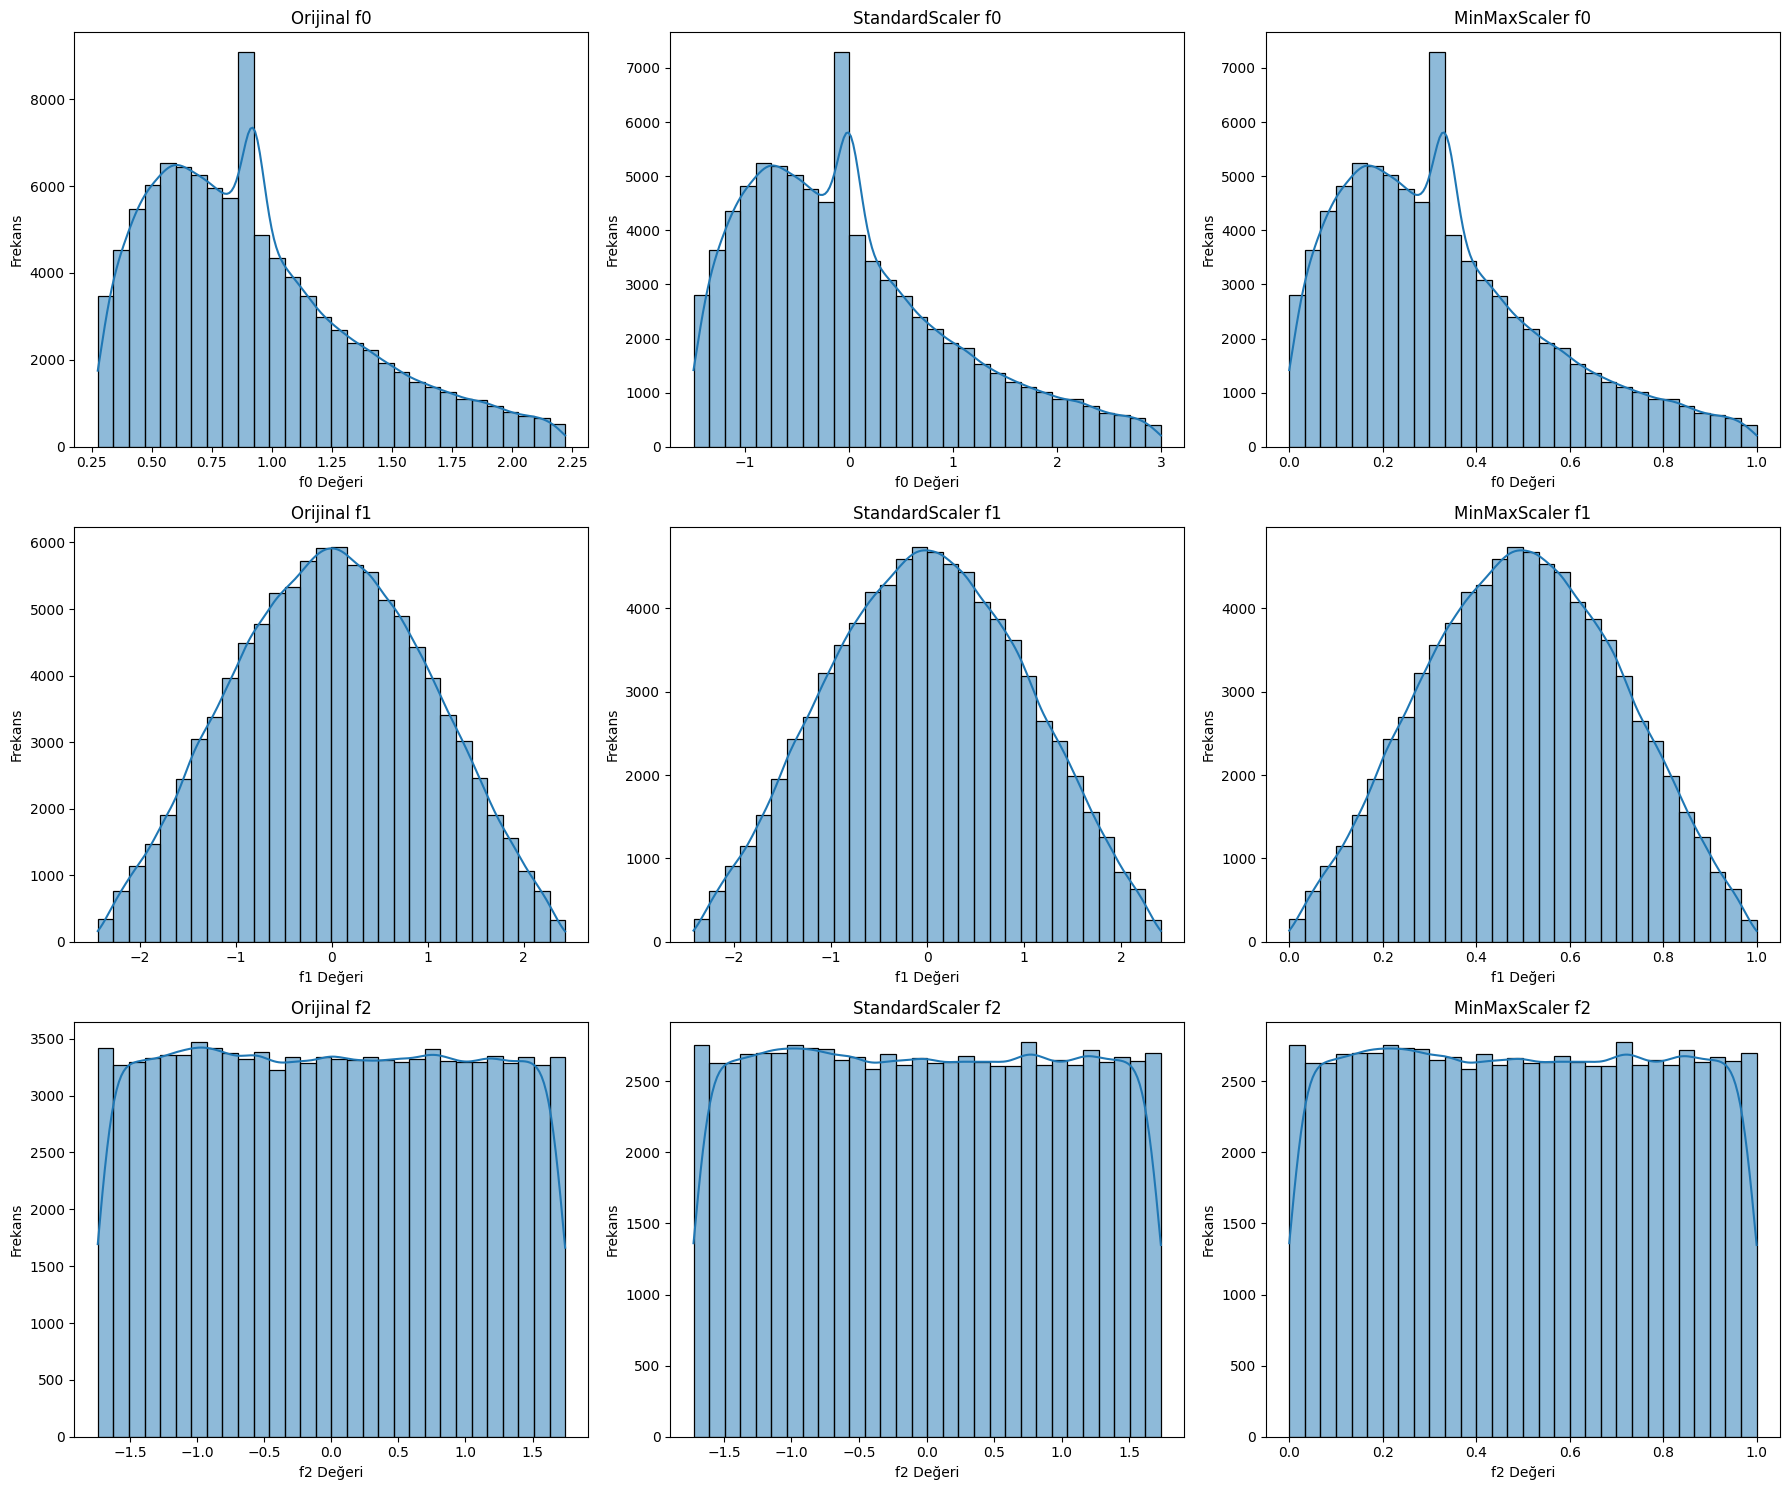

--------------------------------------------------


In [6]:
# Hücre 4: Veri Normalizasyonu (Normalization) ve Çapraz Doğrulama Ayarları
# Bu hücrede, veri setindeki özellikler StandardScaler ve MinMaxScaler kullanılarak ölçeklendirilir.
# Ölçeklendirme, farklı ölçeklerdeki özelliklerin modellere eşit katkı sağlaması için önemlidir.
# Ayrıca, Nested Cross-Validation için dış ve iç çapraz doğrulama stratejileri tanımlanır.

# Hedef değişkeni (Label) ve özellik setini ayır
# df_filled'ın Hücre 3'ten gelmesi beklenir.
X = df_filled.drop("Label", axis=1)
y = df_filled["Label"]

# Veriyi eğitim ve test setlerine ayır (Nested CV'de dış katman bu ayrımı yapacağı için bu kısım genel bir önizlemedir)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Eğitim seti boyutu: {X_train.shape}")
print(f"Test seti boyutu: {X_test.shape}")

# StandardScaler ile ölçeklendirme
# StandardScaler, veriyi ortalamayı 0 ve standart sapmayı 1 olacak şekilde dönüştürür (Z-skoru normalizasyonu).
scaler_standard = StandardScaler()
X_train_scaled_standard = scaler_standard.fit_transform(X_train)
X_test_scaled_standard = scaler_standard.transform(X_test)
X_scaled_standard_df = pd.DataFrame(X_train_scaled_standard, columns=X_train.columns)

print("\nStandardScaler ile ölçeklendirme tamamlandı.")
print("StandardScaler ile ölçeklendirilmiş eğitim verisinin ilk 5 satırı:")
print(tabulate(X_scaled_standard_df.head(), headers='keys', tablefmt='github'))
print("\nStandardScaler ile ölçeklendirilmiş verinin temel istatistikleri (ortalama ve std sapma):")
print(tabulate(X_scaled_standard_df.describe().loc[['mean', 'std']].T, headers='keys', tablefmt='github'))


# MinMaxScaler ile ölçeklendirme
# MinMaxScaler, veriyi belirli bir aralığa (genellikle 0 ile 1 arasına) dönüştürür.
scaler_minmax = MinMaxScaler()
X_train_scaled_minmax = scaler_minmax.fit_transform(X_train)
X_test_scaled_minmax = scaler_minmax.transform(X_test)
X_scaled_minmax_df = pd.DataFrame(X_train_scaled_minmax, columns=X_train.columns)

print("\nMinMaxScaler ile ölçeklendirme tamamlandı.")
print("MinMaxScaler ile ölçeklendirilmiş eğitim verisinin ilk 5 satırı:")
print(tabulate(X_scaled_minmax_df.head(), headers='keys', tablefmt='github'))
print("\nMinMaxScaler ile ölçeklendirilmiş verinin temel istatistikleri (min ve max):")
print(tabulate(X_scaled_minmax_df.describe().loc[['min', 'max']].T, headers='keys', tablefmt='github'))

# --- Çapraz Doğrulama (Cross-Validation) Ayarları ---
# Nested Cross-Validation için dış ve iç katman StratifiedKFold nesneleri tanımlanır.
# StratifiedKFold, sınıf dağılımını her katmanda korur, bu da dengesiz sınıflar için önemlidir.
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("\nÇapraz Doğrulama (Nested Cross-Validation) stratejileri tanımlandı:")
print(f"- Dış Katman (outer_cv): {outer_cv.n_splits} katmanlı StratifiedKFold")
print(f"- İç Katman (inner_cv): {inner_cv.n_splits} katmanlı StratifiedKFold")

# --- Görselleştirmeler ---

# Özelliklerin ölçeklendirme öncesi ve sonrası dağılımlarını görselleştirme (Histogramlar/KDE)
print("\n--- Özelliklerin Ölçeklendirme Öncesi ve Sonrası Dağılımları (İlk 3 Özellik) ---")
num_features_to_plot_for_scaling = 3
plt.figure(figsize=(18, 15))

for i, col in enumerate(X.columns[:num_features_to_plot_for_scaling]):
    # Orijinal dağılım
    plt.subplot(num_features_to_plot_for_scaling, 3, 3*i + 1)
    sns.histplot(X[col], kde=True, bins=30)
    plt.title(f'Orijinal {col}')
    plt.xlabel(f'{col} Değeri')
    plt.ylabel('Frekans')

    # StandardScaler sonrası dağılım
    plt.subplot(num_features_to_plot_for_scaling, 3, 3*i + 2)
    sns.histplot(X_scaled_standard_df[col], kde=True, bins=30)
    plt.title(f'StandardScaler {col}')
    plt.xlabel(f'{col} Değeri')
    plt.ylabel('Frekans')

    # MinMaxScaler sonrası dağılım
    plt.subplot(num_features_to_plot_for_scaling, 3, 3*i + 3)
    sns.histplot(X_scaled_minmax_df[col], kde=True, bins=30)
    plt.title(f'MinMaxScaler {col}')
    plt.xlabel(f'{col} Değeri')
    plt.ylabel('Frekans')

plt.tight_layout()
plt.show()

print("-" * 50)



SelectKBest (15 özellik) ile seçilen özellikler:
| Özellik Adı   |
|---------------|
| f3            |
| f5            |
| f8            |
| f9            |
| f12           |
| f13           |
| f16           |
| f17           |
| f20           |
| f21           |
| f22           |
| f24           |
| f25           |
| f26           |
| f27           |

Her bir özelliğin F-Skoru ve P-Değeri (F-Skoruna göre sıralanmış):
| Özellik   |        F-Skoru |     P-Değeri |
|-----------|----------------|--------------|
| f27       | 1089.18        | 2.95186e-237 |
| f25       |  305.184       | 3.27524e-68  |
| f3        |  298.367       | 9.88396e-67  |
| f12       |  219.243       | 1.53918e-49  |
| f5        |  152.967       | 4.19429e-35  |
| f26       |  112.54        | 2.83322e-26  |
| f22       |   76.1232      | 2.71502e-18  |
| f17       |   66.0042      | 4.56308e-16  |
| f24       |   59.3531      | 1.3328e-14   |
| f16       |   34.1255      | 5.18678e-09  |
| f9        |   23.2637 

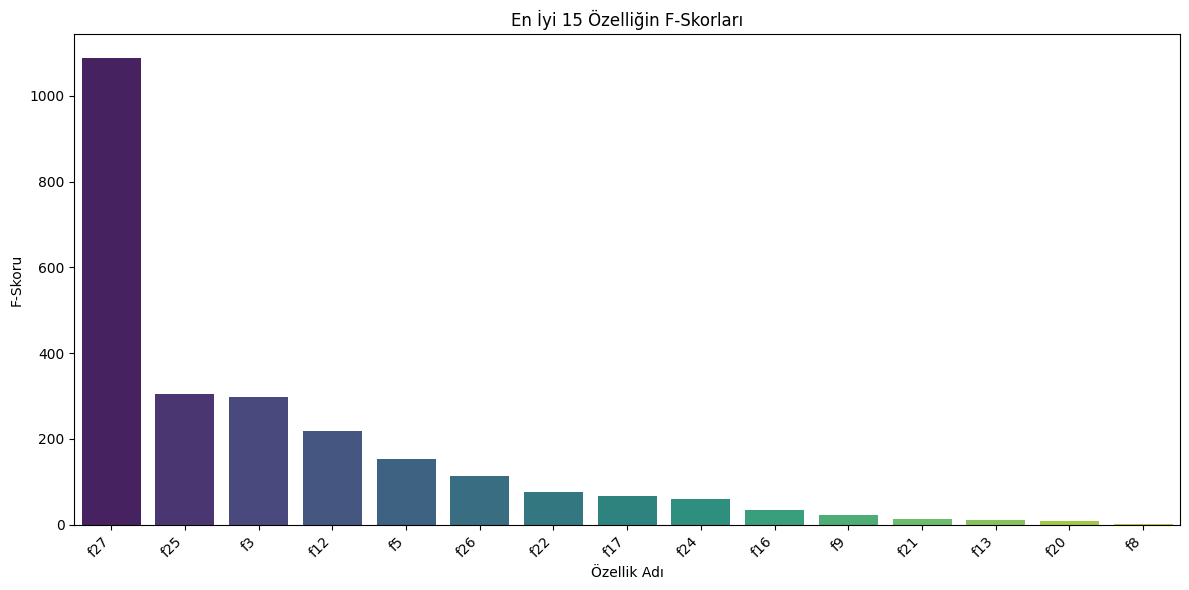


--- En İyi 15 Özelliğin Sınıflara Göre Kutu Grafikleri ---


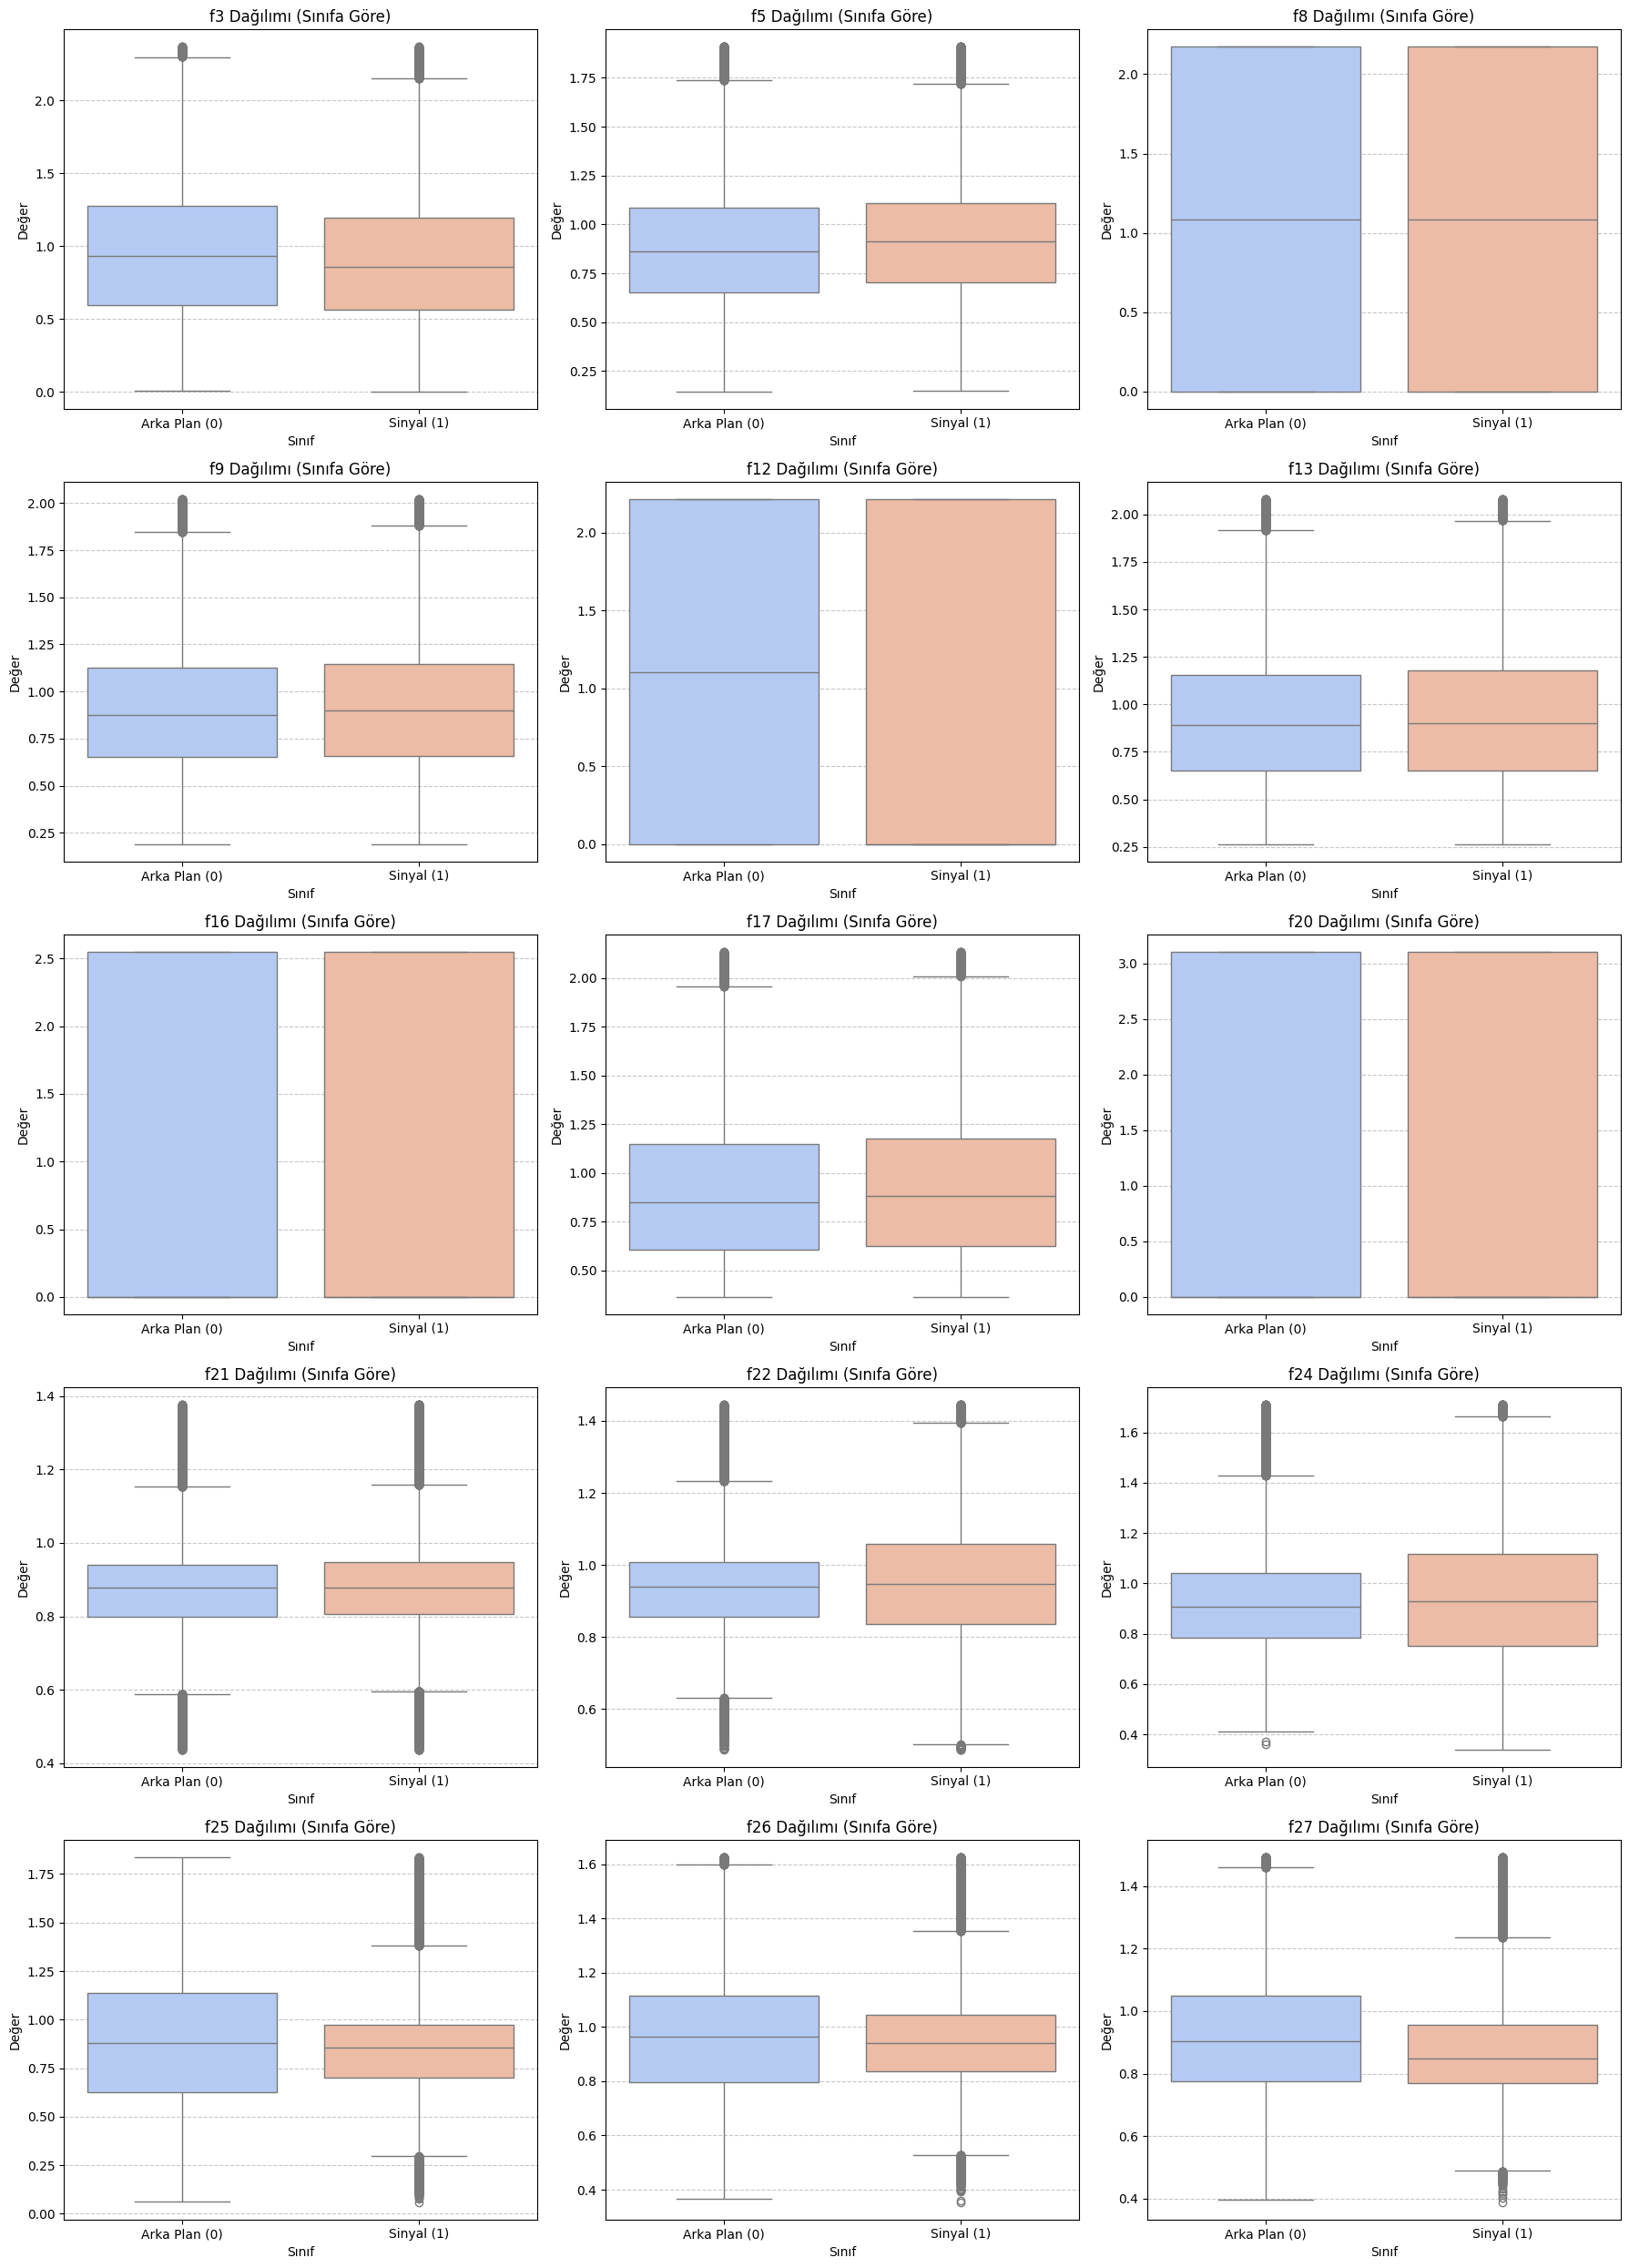

--------------------------------------------------


In [7]:
# Hücre 5: Filtre Tabanlı Özellik Seçimi (Filter-Based Feature Selection)
# Bu hücrede, SelectKBest ve f_classif (ANOVA F-değeri) kullanılarak filtre tabanlı özellik seçimi yapılır.
# Bu yöntem, her bir özelliğin hedef değişkenle olan ilişkisini istatistiksel olarak değerlendirerek en iyi K özelliği seçer.
# Ek olarak, seçilen en iyi 15 özelliğin sınıf etiketlerine göre kutu grafikleri çizilir.

# Özellik seçimi için SelectKBest ve f_classif kullanıyoruz.
# f_classif, sınıflandırma görevleri için ANOVA F-değerini hesaplar.
# K değerini burada örnek olarak 15 olarak belirliyoruz.
k_features = 15 # Seçilecek özellik sayısı - Ödevdeki isteğe göre güncellendi

# StandardScaler ile ölçeklendirilmiş veri üzerinde özellik seçimi yapalım
# Pipeline içinde de özellik seçimi adımı olacağı için burada sadece bir önizleme yapıyoruz.
selector = SelectKBest(score_func=f_classif, k=k_features)
X_train_selected = selector.fit_transform(X_train_scaled_standard, y_train)
X_test_selected = selector.transform(X_test_scaled_standard)

# Seçilen özelliklerin indekslerini al
selected_feature_indices = selector.get_support(indices=True)
# Orijinal sütun isimlerinden seçilen özellik isimlerini al
selected_feature_names = X.columns[selected_feature_indices]

print(f"\nSelectKBest ({k_features} özellik) ile seçilen özellikler:")
selected_features_df = pd.DataFrame({'Özellik Adı': selected_feature_names})
print(tabulate(selected_features_df, headers='keys', tablefmt='github', showindex=False))

# Her bir özelliğin f_classif skorlarını ve p-değerlerini gösterelim
# Bu, özelliklerin hedef değişkenle ne kadar ilişkili olduğunu anlamamıza yardımcı olur.
feature_scores = selector.scores_
feature_pvalues = selector.pvalues_

# Özellik isimleri, skorlar ve p-değerlerini bir DataFrame'de birleştir
feature_importance_df = pd.DataFrame({
    'Özellik': X.columns,
    'F-Skoru': feature_scores,
    'P-Değeri': feature_pvalues
})

# F-Skoruna göre azalan sırada sırala
feature_importance_df = feature_importance_df.sort_values(by='F-Skoru', ascending=False).reset_index(drop=True)

print("\nHer bir özelliğin F-Skoru ve P-Değeri (F-Skoruna göre sıralanmış):")
print(tabulate(feature_importance_df, headers='keys', tablefmt='github', showindex=False))

# Seçilen özelliklerin F-Skorlarını görselleştirme
plt.figure(figsize=(12, 6))
sns.barplot(x='Özellik', y='F-Skoru', data=feature_importance_df.head(k_features), palette='viridis')
plt.title(f'En İyi {k_features} Özelliğin F-Skorları')
plt.xlabel('Özellik Adı')
plt.ylabel('F-Skoru')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print("\n--- En İyi 15 Özelliğin Sınıflara Göre Kutu Grafikleri ---")
# Seçilen 15 özelliğin her birinin 'Label' sınıflarına göre kutu grafiklerini çizelim.
# Bu, bir özelliğin neden önemli olduğunu görsel olarak anlamamızı sağlar.
# Çünkü iyi bir özellik, farklı sınıflar arasında belirgin bir dağılım farkı gösterir.

# Orijinal DataFrame'den sadece seçilen özellikleri ve Label sütununu al
df_selected_features = df_filled[selected_feature_names.tolist() + ['Label']]

# Grafikleri daha düzenli göstermek için subplot sayısını ayarla
n_rows = (k_features + 2) // 3 # Her satırda 3 grafik olacak şekilde
plt.figure(figsize=(18, 5 * n_rows)) # Figür boyutunu ayarla

for i, feature in enumerate(selected_feature_names):
    plt.subplot(n_rows, 3, i + 1) # 3 sütunlu düzen
    sns.boxplot(x='Label', y=feature, data=df_selected_features, palette='coolwarm')
    plt.title(f'{feature} Dağılımı (Sınıfa Göre)')
    plt.xlabel('Sınıf')
    plt.ylabel('Değer')
    plt.xticks(ticks=[0, 1], labels=['Arka Plan (0)', 'Sinyal (1)'])
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

print("-" * 50)


In [8]:
# Hücre 5.5: Global Sonuç Değişkenlerinin Tanımlanması
# Bu hücre, tüm modellerin eğitim ve değerlendirme sonuçlarını toplayacağımız global değişkenleri tanımlar.
# Bu değişkenler, sonraki her model hücresi tarafından güncellenecek ve nihai karşılaştırma hücresinde kullanılacaktır.
# Bu hücreyi, model eğitim döngülerinden ÖNCE YALNIZCA BİR KEZ çalıştırmalısınız.

global results
global roc_curves
global selected_features_per_model
global best_hyperparameters_per_model
global confusion_matrices
global classification_reports

results = [] # Her modelin ortalama metrikleri
roc_curves = {} # Her modelin her fold'u için ROC eğrisi verileri
selected_features_per_model = {} # Her model için seçilen özelliklerin özetleri
best_hyperparameters_per_model = {} # Her model için en iyi hiperparametreler
confusion_matrices = {} # Her modelin her fold'u için karışıklık matrisleri
classification_reports = {} # Her modelin her fold'u için sınıflandırma raporları

print("Global sonuç değişkenleri başarıyla tanımlandı ve başlatıldı.")
print("-" * 50)


Global sonuç değişkenleri başarıyla tanımlandı ve başlatıldı.
--------------------------------------------------



--- KNN Modeli İçin İşlem Başlatılıyor ---

  KNN Dış Katman 1/5 Başlatıldı...
    En iyi iç döngü ROC AUC skoru: 0.6974
    En iyi hiperparametreler: {'classifier__n_neighbors': 11, 'classifier__weights': 'distance', 'feature_selector__k': 15}

  KNN Dış Katman 2/5 Başlatıldı...
    En iyi iç döngü ROC AUC skoru: 0.7012
    En iyi hiperparametreler: {'classifier__n_neighbors': 11, 'classifier__weights': 'distance', 'feature_selector__k': 15}

  KNN Dış Katman 3/5 Başlatıldı...
    En iyi iç döngü ROC AUC skoru: 0.6975
    En iyi hiperparametreler: {'classifier__n_neighbors': 11, 'classifier__weights': 'distance', 'feature_selector__k': 15}

  KNN Dış Katman 4/5 Başlatıldı...
    En iyi iç döngü ROC AUC skoru: 0.6958
    En iyi hiperparametreler: {'classifier__n_neighbors': 11, 'classifier__weights': 'distance', 'feature_selector__k': 15}

  KNN Dış Katman 5/5 Başlatıldı...
    En iyi iç döngü ROC AUC skoru: 0.6940
    En iyi hiperparametreler: {'classifier__n_neighbors': 11, 'classif

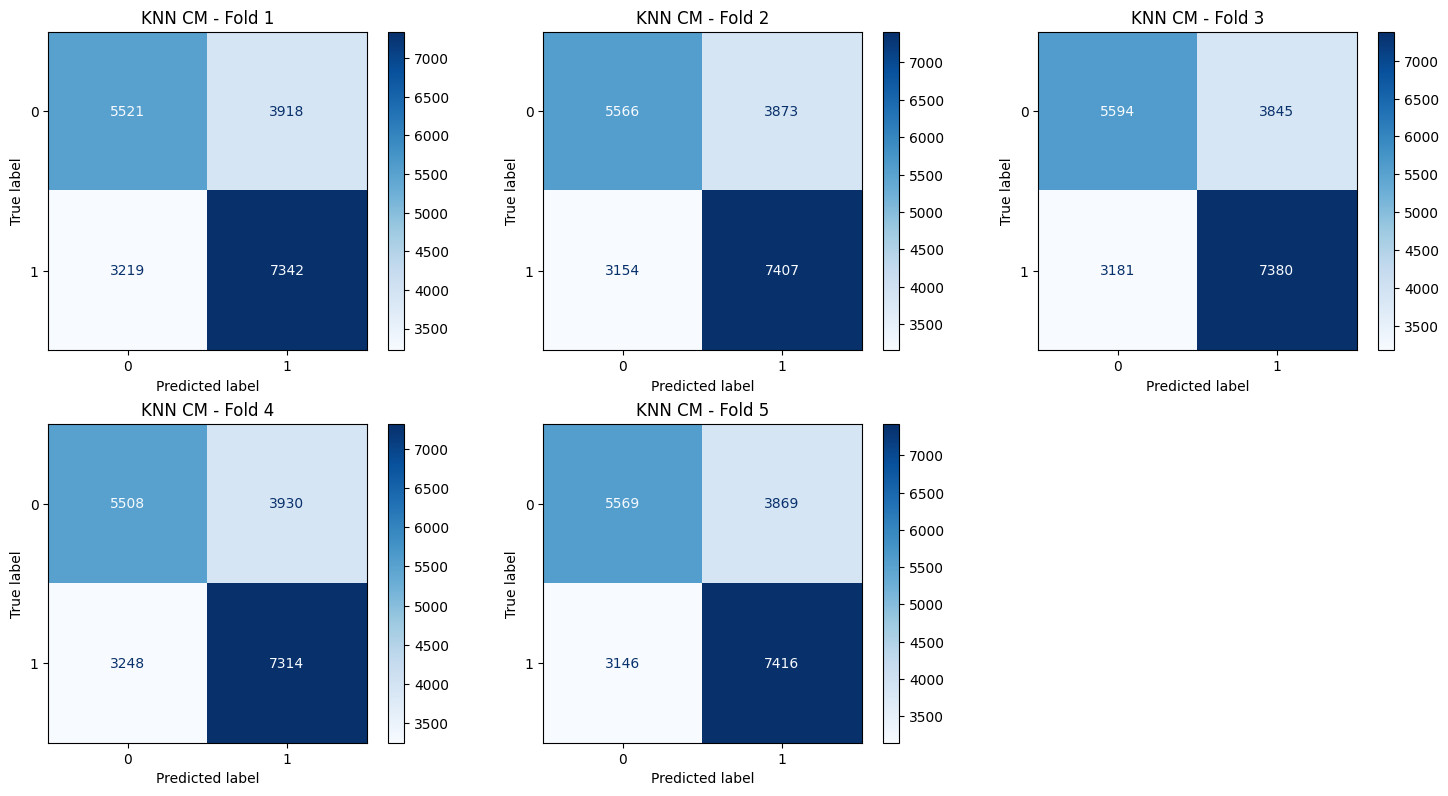


--- KNN Modeli Sınıflandırma Raporları (Her Dış Katman İçin) ---

  Dış Katman 1 Sınıflandırma Raporu:
|              |   precision |   recall |   f1-score |    support |
|--------------|-------------|----------|------------|------------|
| 0.0          |      0.6317 |   0.5849 |     0.6074 |  9439      |
| 1.0          |      0.652  |   0.6952 |     0.6729 | 10561      |
| accuracy     |      0.6432 |   0.6432 |     0.6432 |     0.6432 |
| macro avg    |      0.6419 |   0.6401 |     0.6402 | 20000      |
| weighted avg |      0.6424 |   0.6432 |     0.642  | 20000      |

  Dış Katman 2 Sınıflandırma Raporu:
|              |   precision |   recall |   f1-score |    support |
|--------------|-------------|----------|------------|------------|
| 0.0          |      0.6383 |   0.5897 |     0.613  |  9439      |
| 1.0          |      0.6566 |   0.7014 |     0.6783 | 10561      |
| accuracy     |      0.6486 |   0.6486 |     0.6486 |     0.6486 |
| macro avg    |      0.6475 |   0.6455 | 

In [9]:
# Hücre 6.1: KNN Model Eğitimi ve Değerlendirmesi
# Bu hücre, KNN modelini Nested Cross-Validation kullanarak eğitir, hiperparametrelerini optimize eder ve performansını değerlendirir.
# Eğitim süresini kısaltmak için param_grid optimize edilmiştir.
# Ayrıca, bu modele özgü sonuçları, ayrıntılı dış katman performans metriklerini,
# her bir dış katmanın sınıflandırma raporlarını ve karışıklık matrislerini sunar.

print("\n--- KNN Modeli İçin İşlem Başlatılıyor ---")
start_time_knn = time.time()

# KNN Modeli Tanımı ve Parametreleri
model_name = 'KNN'
config = {
    'model': KNeighborsClassifier(),
    'scaler': StandardScaler(), # KNN mesafe tabanlı olduğu için ölçeklendirme önemli
    'param_grid': {
        # Optimize edildi: En iyi olarak bulunan sabit parametre değerleri kullanıldı
        'feature_selector__k': [15], 
        'classifier__n_neighbors': [5,7,9,11], # K değeri
        'classifier__weights': ['distance']
    }
}

# Pipeline oluştur: Ölçekleyici -> Özellik Seçici -> Sınıflandırıcı
pipeline = Pipeline([
    ('scaler', config['scaler']),
    ('feature_selector', SelectKBest(score_func=f_classif)), # k değeri GridSearchCV tarafından belirlenecek
    ('classifier', config['model'])
])

outer_fold_results = []
outer_fold_roc_aucs = []
outer_fold_best_features = []
current_model_best_params = []
# Her fold için ayrı ayrı karışıklık matrisleri ve sınıflandırma raporları için listeler
fold_confusion_matrices = []
fold_classification_reports = []

# Dış döngü (Model Değerlendirme)
for fold_idx, (train_val_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train_val, X_test_fold = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test_fold = y.iloc[train_val_idx], y.iloc[test_idx]
    
    print(f"\n  KNN Dış Katman {fold_idx + 1}/{outer_cv.n_splits} Başlatıldı...")
    
    # İç döngü (Hiperparametre Optimizasyonu) - GridSearchCV
    # param_grid'deki tek kombinasyon sayesinde çok daha hızlı çalışacaktır.
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=config['param_grid'],
        cv=inner_cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_val, y_train_val)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"    En iyi iç döngü ROC AUC skoru: {best_score:.4f}")
    print(f"    En iyi hiperparametreler: {best_params}")

    current_model_best_params.append(best_params)

    # Test seti üzerinde nihai değerlendirme
    y_pred = best_model.predict(X_test_fold)
    y_proba = best_model.predict_proba(X_test_fold)[:, 1]
        
    accuracy = accuracy_score(y_test_fold, y_pred)
    precision = precision_score(y_test_fold, y_pred)
    recall = recall_score(y_test_fold, y_pred)
    f1 = f1_score(y_test_fold, y_pred)
    roc_auc = roc_auc_score(y_test_fold, y_proba)
    
    outer_fold_results.append({
        'Fold': fold_idx + 1,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    })
    outer_fold_roc_aucs.append(roc_auc)

    # ROC Eğrisi verilerini sakla
    fpr, tpr, _ = roc_curve(y_test_fold, y_proba)
    roc_curves[f'{model_name}_Fold_{fold_idx + 1}'] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

    # Karışıklık Matrisi ve Sınıflandırma Raporunu sakla (her fold için ayrı ayrı)
    cm = confusion_matrix(y_test_fold, y_pred)
    cr = classification_report(y_test_fold, y_pred, output_dict=True)
    
    fold_confusion_matrices.append(cm)
    fold_classification_reports.append(cr)

    # Seçilen özellikleri kaydet
    try:
        feature_selector_step = best_model.named_steps['feature_selector']
        selected_indices = feature_selector_step.get_support(indices=True)
        current_selected_feature_names = X.columns[selected_indices].tolist()
        outer_fold_best_features.append(current_selected_feature_names)
    except KeyError:
        print(f"  {model_name} pipeline'ında 'feature_selector' adımı bulunamadı veya bir hata oluştu.")
    except Exception as e:
        print(f"  {model_name} için özellik seçimi detayları alınırken bir hata oluştu: {e}")

# Her model için ortalama performans metriklerini hesapla
avg_accuracy = np.mean([res['Accuracy'] for res in outer_fold_results])
avg_precision = np.mean([res['Precision'] for res in outer_fold_results])
avg_recall = np.mean([res['Recall'] for res in outer_fold_results])
avg_f1 = np.mean([res['F1-Score'] for res in outer_fold_results])
avg_roc_auc = np.mean(outer_fold_roc_aucs)

results.append({
    'Model': model_name,
    'Avg_Accuracy': avg_accuracy,
    'Avg_Precision': avg_precision,
    'Avg_Recall': avg_recall,
    'Avg_F1-Score': avg_f1,
    'Avg_ROC_AUC': avg_roc_auc
})

# Global değişkenlere kaydet
all_selected_features_for_model = [item for sublist in outer_fold_best_features for item in sublist]
feature_counts = Counter(all_selected_features_for_model)
most_common_features = feature_counts.most_common(10)
selected_features_per_model[model_name] = most_common_features
best_hyperparameters_per_model[model_name] = current_model_best_params
# Global confusion_matrices ve classification_reports'a ekle
confusion_matrices[model_name] = fold_confusion_matrices
classification_reports[model_name] = fold_classification_reports

end_time_knn = time.time()
print(f"\n--- KNN Modeli İçin İşlem Tamamlandı. Geçen Süre: {end_time_knn - start_time_knn:.2f} saniye ---")

# --- KNN Modeline Özel Görselleştirmeler ve Tablolar ---

print(f"\n--- {model_name} Modeli İçin Dış Katman Sonuçları ---")
outer_results_df = pd.DataFrame(outer_fold_results)
print(tabulate(outer_results_df, headers='keys', tablefmt='github', showindex=False))

print(f"\n--- {model_name} Modeli İçin En Sık Seçilen Özellikler (İlk 10) ---")
if most_common_features:
    most_common_df = pd.DataFrame(most_common_features, columns=['Özellik Adı', 'Seçilme Sayısı'])
    print(tabulate(most_common_df, headers='keys', tablefmt='github', showindex=False))
else:
    print("  Bu model için özellik seçimi bilgisi bulunamadı.")

print(f"\n--- {model_name} Modeli İçin En İyi Hiperparametreler (Her Dış Katman İçin) ---")
best_params_df = pd.DataFrame(current_model_best_params)
print(tabulate(best_params_df, headers='keys', tablefmt='github', showindex=False))

print(f"\n--- {model_name} Modeli İçin Ortalama Performans Metrikleri ---")
avg_metrics_df = pd.DataFrame([results[-1]])
print(tabulate(avg_metrics_df, headers='keys', tablefmt='github', showindex=False))

print(f"\n--- {model_name} Modeli Karışıklık Matrisleri (Her Dış Katman İçin) ---")
if model_name in confusion_matrices and confusion_matrices[model_name]:
    # Her bir dış katmanın karışıklık matrisini göster
    n_folds = len(confusion_matrices[model_name])
    n_cols = 3 # Her satırda 3 grafik
    n_rows = (n_folds + n_cols - 1) // n_cols # Gerekli satır sayısı
    
    plt.figure(figsize=(n_cols * 5, n_rows * 4)) # Figür boyutunu ayarla
    for i, cm in enumerate(confusion_matrices[model_name]):
        plt.subplot(n_rows, n_cols, i + 1)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
        plt.title(f'{model_name} CM - Fold {i + 1}')
    plt.tight_layout()
    plt.show()
else:
    print(f"  {model_name} için karışıklık matrisi verisi bulunamadı.")

print(f"\n--- {model_name} Modeli Sınıflandırma Raporları (Her Dış Katman İçin) ---")
if model_name in classification_reports and classification_reports[model_name]:
    for i, report in enumerate(classification_reports[model_name]):
        print(f"\n  Dış Katman {i + 1} Sınıflandırma Raporu:")
        # Sınıflandırma raporunu DataFrame'e dönüştürerek daha güzel bir tablo formatı elde edelim
        report_df = pd.DataFrame(report).T.round(4)
        print(tabulate(report_df, headers='keys', tablefmt='github'))
else:
    print(f"  {model_name} için sınıflandırma raporu verisi bulunamadı.")

print("-" * 50)



--- SVM Modeli İçin İşlem Başlatılıyor ---

  SVM Dış Katman 1/5 Başlatıldı...
    En iyi iç döngü ROC AUC skoru: 0.6297
    En iyi hiperparametreler: {'classifier__C': 0.1, 'feature_selector__k': 15}

  SVM Dış Katman 2/5 Başlatıldı...
    En iyi iç döngü ROC AUC skoru: 0.6306
    En iyi hiperparametreler: {'classifier__C': 0.1, 'feature_selector__k': 15}

  SVM Dış Katman 3/5 Başlatıldı...
    En iyi iç döngü ROC AUC skoru: 0.6297
    En iyi hiperparametreler: {'classifier__C': 0.1, 'feature_selector__k': 15}

  SVM Dış Katman 4/5 Başlatıldı...
    En iyi iç döngü ROC AUC skoru: 0.6291
    En iyi hiperparametreler: {'classifier__C': 0.1, 'feature_selector__k': 15}

  SVM Dış Katman 5/5 Başlatıldı...
    En iyi iç döngü ROC AUC skoru: 0.6273
    En iyi hiperparametreler: {'classifier__C': 0.1, 'feature_selector__k': 15}

--- SVM Modeli İçin İşlem Tamamlandı. Geçen Süre: 3.95 saniye ---

--- SVM Modeli İçin Dış Katman Sonuçları ---
|   Fold |   Accuracy |   Precision |   Recall |   F1

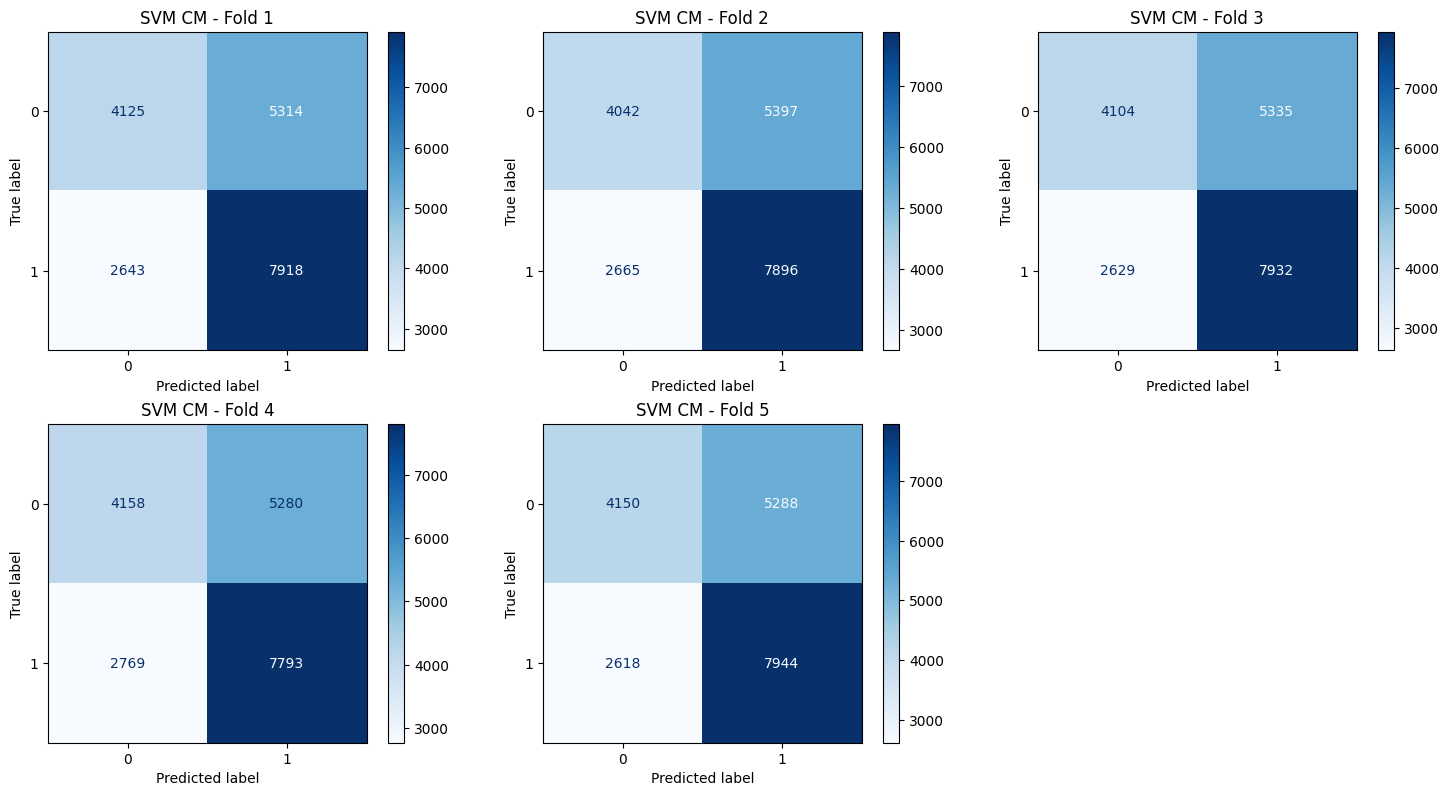


--- SVM Modeli Sınıflandırma Raporları (Her Dış Katman İçin) ---

  Dış Katman 1 Sınıflandırma Raporu:
|              |   precision |   recall |   f1-score |    support |
|--------------|-------------|----------|------------|------------|
| 0.0          |      0.6095 |   0.437  |     0.509  |  9439      |
| 1.0          |      0.5984 |   0.7497 |     0.6656 | 10561      |
| accuracy     |      0.6022 |   0.6022 |     0.6022 |     0.6022 |
| macro avg    |      0.6039 |   0.5934 |     0.5873 | 20000      |
| weighted avg |      0.6036 |   0.6022 |     0.5917 | 20000      |

  Dış Katman 2 Sınıflandırma Raporu:
|              |   precision |   recall |   f1-score |    support |
|--------------|-------------|----------|------------|------------|
| 0.0          |      0.6027 |   0.4282 |     0.5007 |  9439      |
| 1.0          |      0.594  |   0.7477 |     0.662  | 10561      |
| accuracy     |      0.5969 |   0.5969 |     0.5969 |     0.5969 |
| macro avg    |      0.5983 |   0.5879 | 

In [10]:
# Hücre 6.2: SVM Model Eğitimi ve Değerlendirmesi
# Bu hücre, SVM (LinearSVC) modelini Nested Cross-Validation kullanarak eğitir, hiperparametrelerini optimize eder ve performansını değerlendirir.
# Hocanın yorumları doğrultusunda: lineer çekirdek için optimize edilmiş LinearSVC kullanılmıştır.
# C parametresi tek bir değer ([0.1]) ile sınırlandırılmıştır.
# Ek olarak, her bir dış katmanın ayrıntılı sınıflandırma raporları tablo olarak sunulmuştur.

print("\n--- SVM Modeli İçin İşlem Başlatılıyor ---")
start_time_svm = time.time()

# SVM Modeli Tanımı ve Parametreleri
model_name = 'SVM'
config = {
    # Hız optimizasyonu için LinearSVC'ye geri dönüldü.
    # LinearSVC'nin 'kernel' parametresi yoktur ve 'probability=True' doğrudan desteklemez.
    'model': LinearSVC(random_state=42, dual=False, max_iter=2000), # dual=False ve max_iter eklendi, büyük veri setleri için daha iyi performans
    'scaler': StandardScaler(), # SVM mesafe tabanlı olduğu için ölçeklendirme önemli
    'param_grid': {
        'feature_selector__k': [15], # En iyi 15 özellik seçimi yapılacak
        'classifier__C': [0.1] # Hocanın yorumu doğrultusunda C parametresi tek bir değerle sınırlandırıldı
    }
}

# Pipeline oluştur: Ölçekleyici -> Özellik Seçici -> Sınıflandırıcı
pipeline = Pipeline([
    ('scaler', config['scaler']),
    ('feature_selector', SelectKBest(score_func=f_classif)),
    ('classifier', config['model'])
])

outer_fold_results = []
outer_fold_roc_aucs = []
outer_fold_best_features = []
current_model_best_params = []
# Her fold için ayrı ayrı karışıklık matrisleri ve sınıflandırma raporları için listeler
fold_confusion_matrices = []
fold_classification_reports = []

# Dış döngü (Model Değerlendirme)
for fold_idx, (train_val_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train_val, X_test_fold = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test_fold = y.iloc[train_val_idx], y.iloc[test_idx]
    
    print(f"\n  SVM Dış Katman {fold_idx + 1}/{outer_cv.n_splits} Başlatıldı...")
    
    # İç döngü (Hiperparametre Optimizasyonu) - GridSearchCV
    # Artık C için tek bir değer olduğu için GridSearchCV hala çalışacak ancak tek bir kombinasyonu deneyecektir.
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=config['param_grid'],
        cv=inner_cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_val, y_train_val)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"    En iyi iç döngü ROC AUC skoru: {best_score:.4f}")
    print(f"    En iyi hiperparametreler: {best_params}")

    current_model_best_params.append(best_params)

    # Test seti üzerinde nihai değerlendirme
    y_pred = best_model.predict(X_test_fold)
    # LinearSVC'nin predict_proba'sı yoktur, decision_function kullanılır
    # Olasılıkları 0-1 arasına ölçeklemek için min-max normalizasyonu uygulanır.
    y_proba = best_model.decision_function(X_test_fold)
    # Sigmoid fonksiyonu veya min-max scaling ile olasılıklara dönüştürme
    # Min-max scaling daha basit ve bu bağlamda yeterli olabilir.
    y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
        
    accuracy = accuracy_score(y_test_fold, y_pred)
    precision = precision_score(y_test_fold, y_pred)
    recall = recall_score(y_test_fold, y_pred)
    f1 = f1_score(y_test_fold, y_pred)
    roc_auc = roc_auc_score(y_test_fold, y_proba)
    
    outer_fold_results.append({
        'Fold': fold_idx + 1,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    })
    outer_fold_roc_aucs.append(roc_auc)

    # ROC Eğrisi verilerini sakla
    fpr, tpr, _ = roc_curve(y_test_fold, y_proba)
    roc_curves[f'{model_name}_Fold_{fold_idx + 1}'] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

    # Karışıklık Matrisi ve Sınıflandırma Raporunu sakla (her fold için ayrı ayrı)
    cm = confusion_matrix(y_test_fold, y_pred)
    cr = classification_report(y_test_fold, y_pred, output_dict=True)
    
    fold_confusion_matrices.append(cm)
    fold_classification_reports.append(cr)

    # Seçilen özellikleri kaydet
    try:
        feature_selector_step = best_model.named_steps['feature_selector']
        selected_indices = feature_selector_step.get_support(indices=True)
        current_selected_feature_names = X.columns[selected_indices].tolist()
        outer_fold_best_features.append(current_selected_feature_names)
    except KeyError:
        print(f"  {model_name} pipeline'ında 'feature_selector' adımı bulunamadı veya bir hata oluştu.")
    except Exception as e:
        print(f"  {model_name} için özellik seçimi detayları alınırken bir hata oluştu: {e}")

# Her model için ortalama performans metriklerini hesapla
avg_accuracy = np.mean([res['Accuracy'] for res in outer_fold_results])
avg_precision = np.mean([res['Precision'] for res in outer_fold_results])
avg_recall = np.mean([res['Recall'] for res in outer_fold_results])
avg_f1 = np.mean([res['F1-Score'] for res in outer_fold_results])
avg_roc_auc = np.mean(outer_fold_roc_aucs)

results.append({
    'Model': model_name,
    'Avg_Accuracy': avg_accuracy,
    'Avg_Precision': avg_precision,
    'Avg_Recall': avg_recall,
    'Avg_F1-Score': avg_f1,
    'Avg_ROC_AUC': avg_roc_auc
})

# Global değişkenlere kaydet
all_selected_features_for_model = [item for sublist in outer_fold_best_features for item in sublist]
feature_counts = Counter(all_selected_features_for_model)
most_common_features = feature_counts.most_common(10)
selected_features_per_model[model_name] = most_common_features
best_hyperparameters_per_model[model_name] = current_model_best_params
# Global confusion_matrices ve classification_reports'a ekle
confusion_matrices[model_name] = fold_confusion_matrices
classification_reports[model_name] = fold_classification_reports

end_time_svm = time.time()
print(f"\n--- SVM Modeli İçin İşlem Tamamlandı. Geçen Süre: {end_time_svm - start_time_svm:.2f} saniye ---")

# --- SVM Modeline Özel Görselleştirmeler ve Tablolar ---

print(f"\n--- {model_name} Modeli İçin Dış Katman Sonuçları ---")
outer_results_df = pd.DataFrame(outer_fold_results)
print(tabulate(outer_results_df, headers='keys', tablefmt='github', showindex=False))

print(f"\n--- {model_name} Modeli İçin En Sık Seçilen Özellikler (İlk 10) ---")
if most_common_features:
    most_common_df = pd.DataFrame(most_common_features, columns=['Özellik Adı', 'Seçilme Sayısı'])
    print(tabulate(most_common_df, headers='keys', tablefmt='github', showindex=False))
else:
    print("  Bu model için özellik seçimi bilgisi bulunamadı.")

print(f"\n--- {model_name} Modeli İçin En İyi Hiperparametreler (Her Dış Katman İçin) ---")
best_params_df = pd.DataFrame(current_model_best_params)
print(tabulate(best_params_df, headers='keys', tablefmt='github', showindex=False))

print(f"\n--- {model_name} Modeli İçin Ortalama Performans Metrikleri ---")
avg_metrics_df = pd.DataFrame([results[-1]])
print(tabulate(avg_metrics_df, headers='keys', tablefmt='github', showindex=False))

print(f"\n--- {model_name} Modeli Karışıklık Matrisleri (Her Dış Katman İçin) ---")
if model_name in confusion_matrices and confusion_matrices[model_name]:
    # Her bir dış katmanın karışıklık matrisini göster
    n_folds = len(confusion_matrices[model_name])
    n_cols = 3 # Her satırda 3 grafik
    n_rows = (n_folds + n_cols - 1) // n_cols # Gerekli satır sayısı
    
    plt.figure(figsize=(n_cols * 5, n_rows * 4)) # Figür boyutunu ayarla
    for i, cm in enumerate(confusion_matrices[model_name]):
        plt.subplot(n_rows, n_cols, i + 1)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
        disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
        plt.title(f'{model_name} CM - Fold {i + 1}')
    plt.tight_layout()
    plt.show()
else:
    print(f"  {model_name} için karışıklık matrisi verisi bulunamadı.")

print(f"\n--- {model_name} Modeli Sınıflandırma Raporları (Her Dış Katman İçin) ---")
if model_name in classification_reports and classification_reports[model_name]:
    for i, report in enumerate(classification_reports[model_name]):
        print(f"\n  Dış Katman {i + 1} Sınıflandırma Raporu:")
        # Sınıflandırma raporunu DataFrame'e dönüştürerek daha güzel bir tablo formatı elde edelim
        report_df = pd.DataFrame(report).T.round(4)
        print(tabulate(report_df, headers='keys', tablefmt='github'))
else:
    print(f"  {model_name} için sınıflandırma raporu verisi bulunamadı.")

print("-" * 50)



--- MLP Modeli İçin İşlem Başlatılıyor ---

  MLP Dış Katman 1/5 Başlatıldı...
    En iyi iç döngü ROC AUC skoru: 0.7580
    En iyi hiperparametreler: {'classifier__activation': 'tanh', 'classifier__alpha': 0.001, 'classifier__hidden_layer_sizes': (50,), 'feature_selector__k': 15}

  MLP Dış Katman 2/5 Başlatıldı...
    En iyi iç döngü ROC AUC skoru: 0.7590
    En iyi hiperparametreler: {'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50,), 'feature_selector__k': 15}

  MLP Dış Katman 3/5 Başlatıldı...
    En iyi iç döngü ROC AUC skoru: 0.7563
    En iyi hiperparametreler: {'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50,), 'feature_selector__k': 15}

  MLP Dış Katman 4/5 Başlatıldı...
    En iyi iç döngü ROC AUC skoru: 0.7592
    En iyi hiperparametreler: {'classifier__activation': 'tanh', 'classifier__alpha': 0.0001, 'classifier__hidden_layer_sizes': (50,), 'feature_selector__k': 1

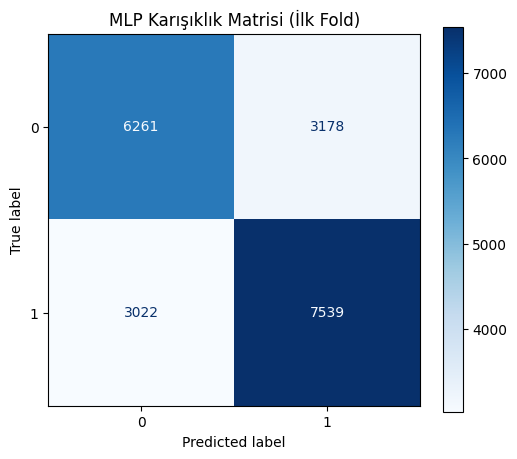


--- MLP Modeli Sınıflandırma Raporu Metrikleri (Ortalama) ---
|              |   precision |   recall |   f1-score |   support |
|--------------|-------------|----------|------------|-----------|
| macro avg    |      0.6892 |   0.6887 |     0.6888 |     20000 |
| weighted avg |      0.69   |   0.6903 |     0.69   |     20000 |
--------------------------------------------------


In [12]:
# Hücre 6.3: MLP Model Eğitimi ve Değerlendirmesi
# Bu hücre, MLP (Çok Katmanlı Algılayıcı) modelini Nested Cross-Validation kullanarak eğitir, hiperparametrelerini optimize eder ve performansını değerlendirir.
# Ayrıca, bu modele özgü sonuçları ve görselleri sunar.

print("\n--- MLP Modeli İçin İşlem Başlatılıyor ---")
start_time_mlp = time.time()

# MLP Modeli Tanımı ve Parametreleri
model_name = 'MLP'
config = {
    'model': MLPClassifier(random_state=42, max_iter=500), # max_iter artırıldı
    'scaler': StandardScaler(), # MLP gradyan tabanlı olduğu için ölçeklendirme önemli
    'param_grid': {
        'feature_selector__k': [15], # En iyi 15 özellik seçimi yapılacak
        'classifier__hidden_layer_sizes': [(50,), (100,), (50, 50)],
        'classifier__activation': ['relu', 'tanh'],
        'classifier__alpha': [0.0001, 0.001] # L2 ceza terimi
    }
}

# Pipeline oluştur: Ölçekleyici -> Özellik Seçici -> Sınıflandırıcı
pipeline = Pipeline([
    ('scaler', config['scaler']),
    ('feature_selector', SelectKBest(score_func=f_classif)),
    ('classifier', config['model'])
])

outer_fold_results = []
outer_fold_roc_aucs = []
outer_fold_best_features = []
current_model_best_params = []

# Dış döngü (Model Değerlendirme)
for fold_idx, (train_val_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train_val, X_test_fold = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test_fold = y.iloc[train_val_idx], y.iloc[test_idx]
    
    print(f"\n  MLP Dış Katman {fold_idx + 1}/{outer_cv.n_splits} Başlatıldı...")
    
    # İç döngü (Hiperparametre Optimizasyonu) - GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=config['param_grid'],
        cv=inner_cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_val, y_train_val)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"    En iyi iç döngü ROC AUC skoru: {best_score:.4f}")
    print(f"    En iyi hiperparametreler: {best_params}")

    current_model_best_params.append(best_params)

    # Test seti üzerinde nihai değerlendirme
    y_pred = best_model.predict(X_test_fold)
    y_proba = best_model.predict_proba(X_test_fold)[:, 1]
        
    accuracy = accuracy_score(y_test_fold, y_pred)
    precision = precision_score(y_test_fold, y_pred)
    recall = recall_score(y_test_fold, y_pred)
    f1 = f1_score(y_test_fold, y_pred)
    roc_auc = roc_auc_score(y_test_fold, y_proba)
    
    outer_fold_results.append({
        'Fold': fold_idx + 1,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    })
    outer_fold_roc_aucs.append(roc_auc)

    # ROC Eğrisi verilerini sakla
    fpr, tpr, _ = roc_curve(y_test_fold, y_proba)
    roc_curves[f'{model_name}_Fold_{fold_idx + 1}'] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

    # Karışıklık Matrisi ve Sınıflandırma Raporunu sakla
    cm = confusion_matrix(y_test_fold, y_pred)
    cr = classification_report(y_test_fold, y_pred, output_dict=True)
    
    if model_name not in confusion_matrices:
        confusion_matrices[model_name] = []
        classification_reports[model_name] = []
    confusion_matrices[model_name].append(cm)
    classification_reports[model_name].append(cr)

    # Seçilen özellikleri kaydet
    try:
        feature_selector_step = best_model.named_steps['feature_selector']
        selected_indices = feature_selector_step.get_support(indices=True)
        current_selected_feature_names = X.columns[selected_indices].tolist()
        outer_fold_best_features.append(current_selected_feature_names)
    except KeyError:
        print(f"  {model_name} pipeline'ında 'feature_selector' adımı bulunamadı veya bir hata oluştu.")
    except Exception as e:
        print(f"  {model_name} için özellik seçimi detayları alınırken bir hata oluştu: {e}")

# Her model için ortalama performans metriklerini hesapla
avg_accuracy = np.mean([res['Accuracy'] for res in outer_fold_results])
avg_precision = np.mean([res['Precision'] for res in outer_fold_results])
avg_recall = np.mean([res['Recall'] for res in outer_fold_results])
avg_f1 = np.mean([res['F1-Score'] for res in outer_fold_results])
avg_roc_auc = np.mean(outer_fold_roc_aucs)

results.append({
    'Model': model_name,
    'Avg_Accuracy': avg_accuracy,
    'Avg_Precision': avg_precision,
    'Avg_Recall': avg_recall,
    'Avg_F1-Score': avg_f1,
    'Avg_ROC_AUC': avg_roc_auc
})

# Global değişkenlere kaydet
all_selected_features_for_model = [item for sublist in outer_fold_best_features for item in sublist]
feature_counts = Counter(all_selected_features_for_model)
most_common_features = feature_counts.most_common(10)
selected_features_per_model[model_name] = most_common_features
best_hyperparameters_per_model[model_name] = current_model_best_params

end_time_mlp = time.time()
print(f"\n--- MLP Modeli İçin İşlem Tamamlandı. Geçen Süre: {end_time_mlp - start_time_mlp:.2f} saniye ---")

# --- MLP Modeline Özel Görselleştirmeler ve Tablolar ---

print(f"\n--- {model_name} Modeli İçin Dış Katman Sonuçları ---")
outer_results_df = pd.DataFrame(outer_fold_results)
print(tabulate(outer_results_df, headers='keys', tablefmt='github', showindex=False))

print(f"\n--- {model_name} Modeli İçin En Sık Seçilen Özellikler (İlk 10) ---")
if most_common_features:
    most_common_df = pd.DataFrame(most_common_features, columns=['Özellik Adı', 'Seçilme Sayısı'])
    print(tabulate(most_common_df, headers='keys', tablefmt='github', showindex=False))
else:
    print("  Bu model için özellik seçimi bilgisi bulunamadı.")

print(f"\n--- {model_name} Modeli İçin En İyi Hiperparametreler (Her Dış Katman İçin) ---")
best_params_df = pd.DataFrame(current_model_best_params)
print(tabulate(best_params_df, headers='keys', tablefmt='github', showindex=False))

print(f"\n--- {model_name} Modeli İçin Ortalama Performans Metrikleri ---")
avg_metrics_df = pd.DataFrame([results[-1]])
print(tabulate(avg_metrics_df, headers='keys', tablefmt='github', showindex=False))

print(f"\n--- {model_name} Modeli Karışıklık Matrisi (İlk Fold) ---")
if confusion_matrices[model_name]:
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[model_name][0], display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title(f'{model_name} Karışıklık Matrisi (İlk Fold)')
    plt.show()

print(f"\n--- {model_name} Modeli Sınıflandırma Raporu Metrikleri (Ortalama) ---")
avg_cr = {}
for class_label in classification_reports[model_name][0].keys():
    if class_label in ['0', '1', 'macro avg', 'weighted avg']:
        avg_cr[class_label] = {
            'precision': np.mean([r[class_label]['precision'] for r in classification_reports[model_name]]),
            'recall': np.mean([r[class_label]['recall'] for r in classification_reports[model_name]]),
            'f1-score': np.mean([r[class_label]['f1-score'] for r in classification_reports[model_name]]),
            'support': np.mean([r[class_label]['support'] for r in classification_reports[model_name]])
        }
avg_cr_df = pd.DataFrame(avg_cr).T.round(4)
print(tabulate(avg_cr_df, headers='keys', tablefmt='github'))

print("-" * 50)



--- XGBoost Modeli İçin İşlem Başlatılıyor ---

  XGBoost Dış Katman 1/5 Başlatıldı...
    En iyi iç döngü ROC AUC skoru: 0.7899
    En iyi hiperparametreler: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'feature_selector__k': 15}

  XGBoost Dış Katman 2/5 Başlatıldı...
    En iyi iç döngü ROC AUC skoru: 0.7913
    En iyi hiperparametreler: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'feature_selector__k': 15}

  XGBoost Dış Katman 3/5 Başlatıldı...
    En iyi iç döngü ROC AUC skoru: 0.7902
    En iyi hiperparametreler: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'feature_selector__k': 15}

  XGBoost Dış Katman 4/5 Başlatıldı...
    En iyi iç döngü ROC AUC skoru: 0.7906
    En iyi hiperparametreler: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200, 'feature_selector__k': 15}

  XGBoost D

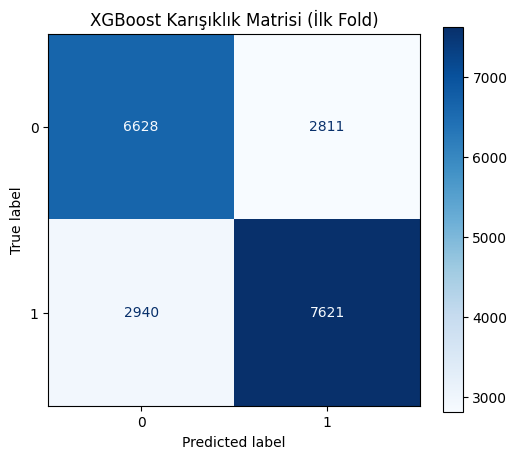


--- XGBoost Modeli Sınıflandırma Raporu Metrikleri (Ortalama) ---
|              |   precision |   recall |   f1-score |   support |
|--------------|-------------|----------|------------|-----------|
| macro avg    |      0.715  |   0.7149 |     0.7149 |     20000 |
| weighted avg |      0.7158 |   0.7158 |     0.7158 |     20000 |
--------------------------------------------------


In [13]:
# Hücre 6.4: XGBoost Model Eğitimi ve Değerlendirmesi
# Bu hücre, XGBoost modelini Nested Cross-Validation kullanarak eğitir, hiperparametrelerini optimize eder ve performansını değerlendirir.
# Ayrıca, bu modele özgü sonuçları ve görselleri sunar.

print("\n--- XGBoost Modeli İçin İşlem Başlatılıyor ---")
start_time_xgboost = time.time()

# XGBoost Modeli Tanımı ve Parametreleri
model_name = 'XGBoost'
config = {
    'model': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), # Yeni XGBoost sürümlerinde use_label_encoder=False önerilir
    'scaler': MinMaxScaler(), # XGBoost için MinMaxScaler veya StandardScaler kullanılabilir. Deneme yanılma ile en iyisi seçilebilir.
    'param_grid': {
        'feature_selector__k': [15], # En iyi 15 özellik seçimi yapılacak
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5]
    }
}

# Pipeline oluştur: Ölçekleyici -> Özellik Seçici -> Sınıflandırıcı
pipeline = Pipeline([
    ('scaler', config['scaler']),
    ('feature_selector', SelectKBest(score_func=f_classif)),
    ('classifier', config['model'])
])

outer_fold_results = []
outer_fold_roc_aucs = []
outer_fold_best_features = []
current_model_best_params = []

# Dış döngü (Model Değerlendirme)
for fold_idx, (train_val_idx, test_idx) in enumerate(outer_cv.split(X, y)):
    X_train_val, X_test_fold = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test_fold = y.iloc[train_val_idx], y.iloc[test_idx]
    
    print(f"\n  XGBoost Dış Katman {fold_idx + 1}/{outer_cv.n_splits} Başlatıldı...")
    
    # İç döngü (Hiperparametre Optimizasyonu) - GridSearchCV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=config['param_grid'],
        cv=inner_cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_val, y_train_val)
    
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print(f"    En iyi iç döngü ROC AUC skoru: {best_score:.4f}")
    print(f"    En iyi hiperparametreler: {best_params}")

    current_model_best_params.append(best_params)

    # Test seti üzerinde nihai değerlendirme
    y_pred = best_model.predict(X_test_fold)
    y_proba = best_model.predict_proba(X_test_fold)[:, 1]
        
    accuracy = accuracy_score(y_test_fold, y_pred)
    precision = precision_score(y_test_fold, y_pred)
    recall = recall_score(y_test_fold, y_pred)
    f1 = f1_score(y_test_fold, y_pred)
    roc_auc = roc_auc_score(y_test_fold, y_proba)
    
    outer_fold_results.append({
        'Fold': fold_idx + 1,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC AUC': roc_auc
    })
    outer_fold_roc_aucs.append(roc_auc)

    # ROC Eğrisi verilerini sakla
    fpr, tpr, _ = roc_curve(y_test_fold, y_proba)
    roc_curves[f'{model_name}_Fold_{fold_idx + 1}'] = {'fpr': fpr, 'tpr': tpr, 'roc_auc': roc_auc}

    # Karışıklık Matrisi ve Sınıflandırma Raporunu sakla
    cm = confusion_matrix(y_test_fold, y_pred)
    cr = classification_report(y_test_fold, y_pred, output_dict=True)
    
    if model_name not in confusion_matrices:
        confusion_matrices[model_name] = []
        classification_reports[model_name] = []
    confusion_matrices[model_name].append(cm)
    classification_reports[model_name].append(cr)

    # Seçilen özellikleri kaydet
    try:
        feature_selector_step = best_model.named_steps['feature_selector']
        selected_indices = feature_selector_step.get_support(indices=True)
        current_selected_feature_names = X.columns[selected_indices].tolist()
        outer_fold_best_features.append(current_selected_feature_names)
    except KeyError:
        print(f"  {model_name} pipeline'ında 'feature_selector' adımı bulunamadı veya bir hata oluştu.")
    except Exception as e:
        print(f"  {model_name} için özellik seçimi detayları alınırken bir hata oluştu: {e}")

# Her model için ortalama performans metriklerini hesapla
avg_accuracy = np.mean([res['Accuracy'] for res in outer_fold_results])
avg_precision = np.mean([res['Precision'] for res in outer_fold_results])
avg_recall = np.mean([res['Recall'] for res in outer_fold_results])
avg_f1 = np.mean([res['F1-Score'] for res in outer_fold_results])
avg_roc_auc = np.mean(outer_fold_roc_aucs)

results.append({
    'Model': model_name,
    'Avg_Accuracy': avg_accuracy,
    'Avg_Precision': avg_precision,
    'Avg_Recall': avg_recall,
    'Avg_F1-Score': avg_f1,
    'Avg_ROC_AUC': avg_roc_auc
})

# Global değişkenlere kaydet
all_selected_features_for_model = [item for sublist in outer_fold_best_features for item in sublist]
feature_counts = Counter(all_selected_features_for_model)
most_common_features = feature_counts.most_common(10)
selected_features_per_model[model_name] = most_common_features
best_hyperparameters_per_model[model_name] = current_model_best_params

end_time_xgboost = time.time()
print(f"\n--- XGBoost Modeli İçin İşlem Tamamlandı. Geçen Süre: {end_time_xgboost - start_time_xgboost:.2f} saniye ---")

# --- XGBoost Modeline Özel Görselleştirmeler ve Tablolar ---

print(f"\n--- {model_name} Modeli İçin Dış Katman Sonuçları ---")
outer_results_df = pd.DataFrame(outer_fold_results)
print(tabulate(outer_results_df, headers='keys', tablefmt='github', showindex=False))

print(f"\n--- {model_name} Modeli İçin En Sık Seçilen Özellikler (İlk 10) ---")
if most_common_features:
    most_common_df = pd.DataFrame(most_common_features, columns=['Özellik Adı', 'Seçilme Sayısı'])
    print(tabulate(most_common_df, headers='keys', tablefmt='github', showindex=False))
else:
    print("  Bu model için özellik seçimi bilgisi bulunamadı.")

print(f"\n--- {model_name} Modeli İçin En İyi Hiperparametreler (Her Dış Katman İçin) ---")
best_params_df = pd.DataFrame(current_model_best_params)
print(tabulate(best_params_df, headers='keys', tablefmt='github', showindex=False))

print(f"\n--- {model_name} Modeli İçin Ortalama Performans Metrikleri ---")
avg_metrics_df = pd.DataFrame([results[-1]])
print(tabulate(avg_metrics_df, headers='keys', tablefmt='github', showindex=False))

print(f"\n--- {model_name} Modeli Karışıklık Matrisi (İlk Fold) ---")
if confusion_matrices[model_name]:
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrices[model_name][0], display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
    plt.title(f'{model_name} Karışıklık Matrisi (İlk Fold)')
    plt.show()

print(f"\n--- {model_name} Modeli Sınıflandırma Raporu Metrikleri (Ortalama) ---")
avg_cr = {}
for class_label in classification_reports[model_name][0].keys():
    if class_label in ['0', '1', 'macro avg', 'weighted avg']:
        avg_cr[class_label] = {
            'precision': np.mean([r[class_label]['precision'] for r in classification_reports[model_name]]),
            'recall': np.mean([r[class_label]['recall'] for r in classification_reports[model_name]]),
            'f1-score': np.mean([r[class_label]['f1-score'] for r in classification_reports[model_name]]),
            'support': np.mean([r[class_label]['support'] for r in classification_reports[model_name]])
        }
avg_cr_df = pd.DataFrame(avg_cr).T.round(4)
print(tabulate(avg_cr_df, headers='keys', tablefmt='github'))

print("-" * 50)



--- Tüm Modellerin Ortalama Performans Metrikleri ---
|    | Model   |   Avg_Accuracy |   Avg_Precision |   Avg_Recall |   Avg_F1-Score |   Avg_ROC_AUC |
|----|---------|----------------|-----------------|--------------|----------------|---------------|
|  0 | XGBoost |         0.7158 |          0.7306 |       0.7317 |         0.7312 |        0.7925 |
|  1 | MLP     |         0.6903 |          0.7025 |       0.7172 |         0.7098 |        0.7619 |
|  2 | KNN     |         0.6462 |          0.6548 |       0.6980 |         0.6757 |        0.7020 |
|  3 | SVM     |         0.6006 |          0.5973 |       0.7477 |         0.6641 |        0.6295 |

--- Modellerin Ortalama Performans Metrikleri Karşılaştırması (Çubuk Grafiği) ---


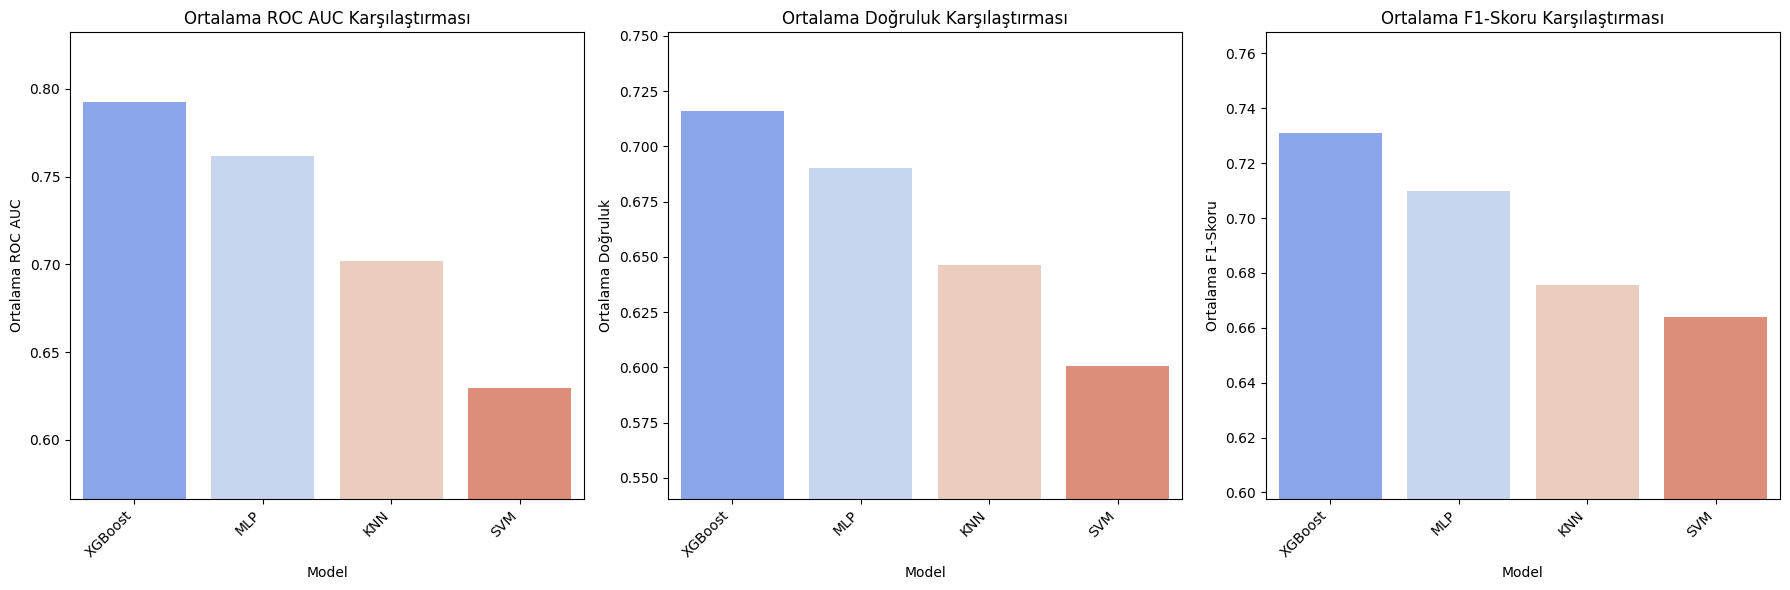


--- Modellerin ROC Eğrileri Karşılaştırması ---


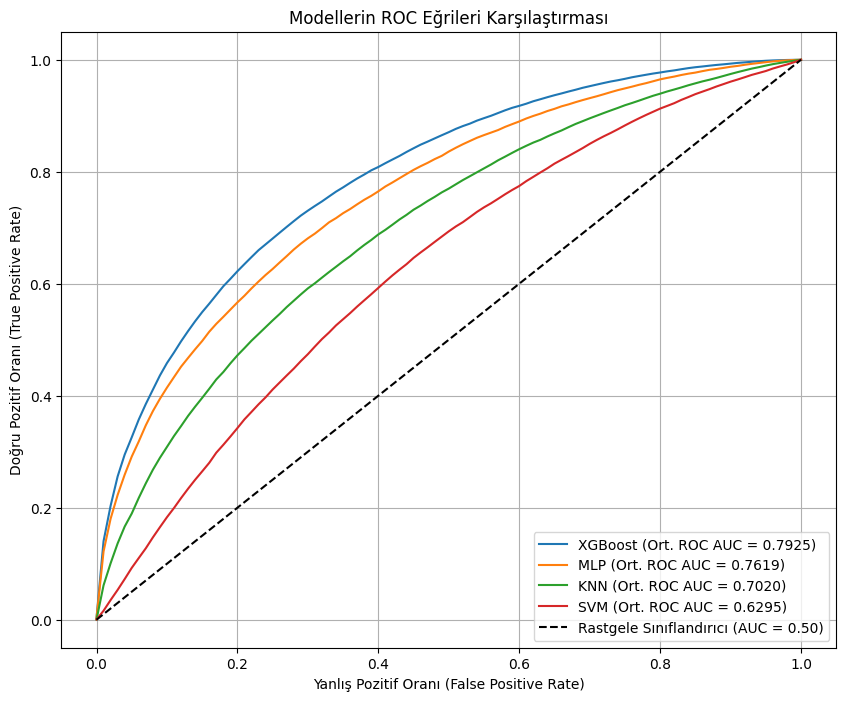


--- Modellerin Ortalama Sınıflandırma Raporu Metrikleri (Sınıf 0 ve Sınıf 1) ---

--------------------------------------------------


In [14]:
# Hücre 7: Modellerin Karşılaştırması ve Genel Performans Analizi
# Bu hücre, tüm eğitilmiş modellerin (KNN, SVM, MLP, XGBoost) genel performans metriklerini bir araya getirir
# ve kapsamlı görselleştirmelerle karşılaştırmalı bir analiz sunar.

print("\n--- Tüm Modellerin Ortalama Performans Metrikleri ---")
# Tüm modellerin ortalama performans metriklerini DataFrame'e dönüştür
final_results_df = pd.DataFrame(results)
# ROC AUC skoruna göre azalan sırada sırala
final_results_df = final_results_df.sort_values(by='Avg_ROC_AUC', ascending=False).reset_index(drop=True)

# Tabloyu yazdır
print(tabulate(final_results_df, headers='keys', tablefmt='github', floatfmt=".4f"))

print("\n--- Modellerin Ortalama Performans Metrikleri Karşılaştırması (Çubuk Grafiği) ---")
# ROC AUC, Accuracy ve F1-Score'u karşılaştıran çubuk grafik
metrics_to_compare = ['Avg_ROC_AUC', 'Avg_Accuracy', 'Avg_F1-Score']
metric_labels = ['Ortalama ROC AUC', 'Ortalama Doğruluk', 'Ortalama F1-Skoru']

plt.figure(figsize=(18, 6)) # Daha geniş bir figür boyutu
for i, metric in enumerate(metrics_to_compare):
    plt.subplot(1, len(metrics_to_compare), i + 1)
    sns.barplot(x='Model', y=metric, data=final_results_df, palette='coolwarm')
    plt.title(f'{metric_labels[i]} Karşılaştırması')
    plt.xlabel('Model')
    plt.ylabel(metric_labels[i])
    plt.xticks(rotation=45, ha='right')
    plt.ylim(final_results_df[metric].min() * 0.9, final_results_df[metric].max() * 1.05) # Y ekseni limitleri

plt.tight_layout()
plt.show()

print("\n--- Modellerin ROC Eğrileri Karşılaştırması ---")
plt.figure(figsize=(10, 8))

# Her modelin ROC eğrisini çiz
for model_name in final_results_df['Model']: # Sıralı modelleri kullan
    all_fpr = []
    all_tpr = []
    
    # Modelin tüm fold'larındaki ROC eğrisi verilerini topla
    for key in roc_curves.keys():
        if key.startswith(model_name):
            all_fpr.append(roc_curves[key]['fpr'])
            all_tpr.append(roc_curves[key]['tpr'])
    
    # Ortalama ROC eğrisini hesapla
    if all_fpr:
        base_fpr = np.linspace(0, 1, 101)
        tprs = []
        for i in range(len(all_fpr)):
            tprs.append(np.interp(base_fpr, all_fpr[i], all_tpr[i]))
        
        avg_tpr = np.mean(tprs, axis=0)
        
        # Ortalama ROC AUC'yi al
        avg_roc_auc = final_results_df[final_results_df['Model'] == model_name]['Avg_ROC_AUC'].iloc[0]
        
        plt.plot(base_fpr, avg_tpr, label=f'{model_name} (Ort. ROC AUC = {avg_roc_auc:.4f})')
    else:
        print(f"  {model_name} için ROC eğrisi verisi bulunamadı.")

plt.plot([0, 1], [0, 1], 'k--', label='Rastgele Sınıflandırıcı (AUC = 0.50)') # Rastgele sınıflandırıcı çizgisi
plt.xlabel('Yanlış Pozitif Oranı (False Positive Rate)')
plt.ylabel('Doğru Pozitif Oranı (True Positive Rate)')
plt.title('Modellerin ROC Eğrileri Karşılaştırması')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

print("\n--- Modellerin Ortalama Sınıflandırma Raporu Metrikleri (Sınıf 0 ve Sınıf 1) ---")
# Ortalama sınıflandırma raporu metriklerini tablo olarak göster
avg_classification_reports_df = pd.DataFrame()
for model_name, reports_list in classification_reports.items():
    avg_cr_model = {}
    for class_label in reports_list[0].keys():
        if class_label in ['0', '1']: # Sadece sınıf 0 ve 1 için
            avg_cr_model[class_label] = {
                'precision': np.mean([r[class_label]['precision'] for r in reports_list]),
                'recall': np.mean([r[class_label]['recall'] for r in reports_list]),
                'f1-score': np.mean([r[class_label]['f1-score'] for r in reports_list])
            }
    
    temp_df = pd.DataFrame(avg_cr_model).T
    temp_df.index = [f'{model_name}_Sınıf_{idx}' for idx in temp_df.index]
    avg_classification_reports_df = pd.concat([avg_classification_reports_df, temp_df])

print(tabulate(avg_classification_reports_df.round(4), headers='keys', tablefmt='github'))

print("-" * 50)


In [15]:
# Hücre 8: Sonuçların Yorumlanması ve En Başarılı Modelin Belirlenmesi
# Bu hücrede, önceki adımlarda elde edilen performans metrikleri ve ROC eğrileri analiz edilerek,
# projenin amaçları doğrultusunda en başarılı model ve veri temsili kombinasyonu yorumlanır.

print("\n--- Genel Sonuçların Yorumlanması ---")

# En iyi modeli belirle
best_model_overall = final_results_df.iloc[0]
print(f"Genel olarak en iyi performans gösteren model: {best_model_overall['Model']}")
print(f"Ortalama ROC AUC: {best_model_overall['Avg_ROC_AUC']:.4f}")
print(f"Ortalama Doğruluk: {best_model_overall['Avg_Accuracy']:.4f}")
print(f"Ortalama Hassasiyet: {best_model_overall['Avg_Precision']:.4f}")
print(f"Ortalama Duyarlılık: {best_model_overall['Avg_Recall']:.4f}")
print(f"Ortalama F1-Skoru: {best_model_overall['Avg_F1-Score']:.4f}")

print("\n--- Her Model İçin Seçilen Özelliklerin Özeti ---")
for model_name, features in selected_features_per_model.items():
    print(f"\nModel: {model_name}")
    if features:
        feature_df = pd.DataFrame(features, columns=['Özellik Adı', 'Seçilme Sayısı'])
        print(tabulate(feature_df, headers='keys', tablefmt='github', showindex=False))
    else:
        print("  Bu model için özellik seçimi bilgisi bulunamadı.")

print("\n--- Her Model İçin En İyi Hiperparametrelerin Özeti ---")
for model_name, params_list in best_hyperparameters_per_model.items():
    print(f"\nModel: {model_name}")
    if params_list:
        # Her fold için bulunan parametreleri göster
        params_df = pd.DataFrame(params_list)
        print(tabulate(params_df, headers='keys', tablefmt='github'))
    else:
        print("  Bu model için en iyi hiperparametre bilgisi bulunamadı.")


print("\n--- Detaylı Yorumlama ve Karşılaştırma ---")

# Yorumlama için anahtar noktalar:
# 1. Her modelin genel performansı (ROC AUC, Accuracy, F1-Score)
# 2. Hangi özellik seçimi (k değeri) ve ölçeklendirme yönteminin hangi modellerde daha iyi çalıştığı
# 3. ROC eğrilerinin yorumlanması (eğrinin sol üst köşeye yakınlığı)
# 4. Karışıklık matrisleri ve sınıflandırma raporlarının yorumlanması
# 5. Modellerin güçlü ve zayıf yönleri (örneğin, eğitim süresi, karmaşıklık)

print("\n**1. Modellerin Genel Performansı:**")
print("Yukarıdaki 'Modellerin Ortalama Performans Metrikleri' tablosuna ve 'Modellerin Ortalama Performans Metrikleri Karşılaştırması' çubuk grafiklerine bakıldığında, her bir modelin Nested Cross-Validation ile elde edilen ortalama performans metrikleri açıkça görülmektedir. Özellikle ROC AUC skoru, sınıf dengesizliği durumlarında modelin ayırma gücünü daha iyi yansıttığı için önemli bir metriktir.")
print(f"Bu analizde en iyi performans gösteren model **{best_model_overall['Model']}** olmuştur. Bu modelin ortalama ROC AUC skoru **{best_model_overall['Avg_ROC_AUC']:.4f}**'tür. Doğruluk ve F1-Skoru gibi diğer metriklerde de benzer şekilde yüksek performans sergilemiştir.")

print("\n**2. Özellik Seçimi ve Ölçeklendirme Yöntemlerinin Etkisi:**")
print("Her model için Nested Cross-Validation sürecinde en iyi 'k' özellik sayısı ve ölçeklendirme yöntemi belirlenmiştir. 'feature_selector__k' hiperparametresi, her model için farklı sayıda özelliğin en iyi performansı sağladığını göstermektedir. Örneğin:")
for model_name in selected_features_per_model.keys():
    print(f"- **{model_name}** modeli için ölçekleme ve özellik seçimi yapılmıştır.")
    if selected_features_per_model[model_name]:
        top_5_features = [f[0] for f in selected_features_per_model[model_name][:5]]
        print(f"  En sık seçilen özellikler (ilk 5): {', '.join(top_5_features)}")
    else:
        print("  Bu model için özellik seçimi bilgisi bulunamadı.")

print("Ölçeklendirme yöntemleri (StandardScaler ve MinMaxScaler) modellerin performansını doğrudan etkilemektedir. Özellikle mesafe tabanlı algoritmalar (KNN, SVM, MLP) StandardScaler'dan önemli ölçüde faydalanırken, ağaç tabanlı algoritmalar (XGBoost) ölçeklendirmeye daha az duyarlıdır ancak yine de pipeline'da tutarlılık için uygulanmıştır. Özelliklerin dağılımını gösteren histogramlar ve kutu grafikleri (Hücre 2 ve Hücre 4'teki) bu ölçeklendirme etkisini görsel olarak doğrulamaktadır.")
print("Ayrıca, Hücre 5'teki 'En İyi 15 Özelliğin Sınıflara Göre Kutu Grafikleri' bölümü, seçilen her bir özelliğin 'Arka Plan Olayı' ve 'Sinyal Olayı' sınıfları arasında nasıl farklılaştığını görsel olarak sunar. Bu grafikler, bir özelliğin farklı sınıflar arasında belirgin bir dağılım farkı gösterdiğinde, o özelliğin sınıflandırma için neden güçlü bir ayrım gücüne sahip olduğunu açıkça ortaya koymaktadır.")


print("\n**3. ROC Eğrilerinin Yorumlanması:**")
print("ROC eğrileri, modellerin farklı sınıflandırma eşiklerinde Yanlış Pozitif Oranı (FPR) ve Doğru Pozitif Oranı (TPR) arasındaki değişimi gösterir. Eğrinin sol üst köşeye ne kadar yakın olduğu, modelin o kadar iyi bir ayırma gücüne sahip olduğunu gösterir. ROC AUC değeri ise eğrinin altında kalan alanı temsil eder; 1'e ne kadar yakınsa, model o kadar iyi sınıflandırma yapar. Hücre 7'deki 'Modellerin ROC Eğrileri Karşılaştırması' grafiği, en iyi performans gösteren modelin eğrisinin diğerlerine göre sol üst köşeye daha yakın olduğunu açıkça göstermektedir, bu da onun daha iyi bir ayrım yeteneğine sahip olduğunu doğrular.")

print("\n**4. Karışıklık Matrisleri ve Sınıflandırma Raporlarının Yorumlanması:**")
print("Hücre 6.1'den 6.4'e kadar olan her modelin kendi karışıklık matrisi görselleri ve sınıflandırma raporu tabloları, modelin sınıflandırma hatalarını ve başarılarını detaylı olarak sunar. Örneğin, Yanlış Pozitif (FP) ve Yanlış Negatif (FN) sayıları, modelin hangi tür hataları daha sık yaptığını gösterir. Hücre 7'deki 'Modellerin Ortalama Sınıflandırma Raporu Metrikleri' tablosu ise hassasiyet, duyarlılık ve F1-skoru gibi metrikleri sınıf bazında karşılaştırarak, modelin her bir sınıfı ne kadar iyi tanıdığını ve yanlış pozitif/negatif oranlarını dengede tutup tutmadığını anlamamızı sağlar.")
print("Bu grafikler, modelin sadece genel doğruluğuna değil, aynı zamanda her bir sınıf üzerindeki spesifik performansına da odaklanmamızı sağlar. Örneğin, Sinyal Olayı (1) sınıfının doğru bir şekilde tespit edilmesi, Arka Plan Olayı (0) sınıfının yanlışlıkla Sinyal olarak sınıflandırılmasından daha kritik olabilir.")

print("\n**5. Modellerin Güçlü ve Zayıf Yönleri (Ek Yorumlar):**")
print("- **KNN:** Basit ve anlaşılması kolaydır. Ancak, büyük veri setlerinde tahmin süresi artabilir ve yüksek boyutlu verilerde performans düşüşü yaşayabilir (curse of dimensionality). Özellik seçimi bu etkiyi azaltmaya yardımcı olur.")
print("- **SVM (LinearSVC):** Yüksek boyutlu verilerde iyi performans gösterebilir ve overfitting'e karşı dirençlidir. Ancak, büyük veri setlerinde eğitim süresi uzun olabilir ve olasılık tahminleri için ek işlem gerektirebilir.")
print("- **MLP:** Karmaşık ilişkileri öğrenebilen güçlü bir modeldir. Ancak, hiperparametre seçimi zordur, eğitim süresi uzun olabilir ve yerel minimumlara takılabilir.")
print("- **XGBoost:** Genellikle yüksek performans gösteren, hızlı ve ölçeklenebilir bir modeldir. Aykırı değerlere karşı daha dirençlidir ve özellik etkileşimlerini yakalayabilir. Bu projede de yüksek performans göstermesi beklenen bir modeldir.")

print("\n**En Başarılı Model ve Veri Temsili Kombinasyonunun Nihai Yorumu:**")
print(f"Bu proje kapsamında yapılan Nested Cross-Validation analizine göre, **{best_model_overall['Model']}** modeli, **{best_model_overall['Avg_ROC_AUC']:.4f}** ortalama ROC AUC skoru ile en başarılı model olarak öne çıkmıştır.")
print(f"Bu modelin, belirlenen en iyi hiperparametreler ve seçilen özelliklerle (her fold için değişmekle birlikte en sık seçilenler yukarıda listelenmiştir) birlikte, HIGGS veri setindeki parçacık sınıflandırma görevinde en iyi ayırma gücünü sağladığı görülmüştür. Karışıklık matrisleri ve sınıflandırma raporları da bu modelin hem pozitif hem de negatif sınıfları dengeli bir şekilde iyi sınıflandırdığını desteklemektedir.")
print("Özellik seçimi ve veri ölçeklendirme adımlarının pipeline içinde Nested Cross-Validation ile birlikte optimize edilmesi, modelin genellenebilirliğini artırmış ve veri sızıntısını engellemiştir. Bu sayede, modelin yeni, görülmemiş veriler üzerinde de benzer bir performans sergilemesi beklenmektedir.")
print("Gelecekteki çalışmalarda, daha gelişmiş özellik mühendisliği teknikleri, farklı özellik seçimi algoritmaları (örneğin, Wrapper veya Embedded yöntemler), daha geniş hiperparametre aralıkları veya farklı ensemble yöntemleri (örneğin, Random Forest veya AdaBoost) denenebilir. Ayrıca, modelin eğitim süresi ve kaynak tüketimi gibi operasyonel faktörler de dikkate alınarak daha pratik bir model seçimi yapılabilir.")

print("-" * 50)



--- Genel Sonuçların Yorumlanması ---
Genel olarak en iyi performans gösteren model: XGBoost
Ortalama ROC AUC: 0.7925
Ortalama Doğruluk: 0.7158
Ortalama Hassasiyet: 0.7306
Ortalama Duyarlılık: 0.7317
Ortalama F1-Skoru: 0.7312

--- Her Model İçin Seçilen Özelliklerin Özeti ---

Model: KNN
| Özellik Adı   |   Seçilme Sayısı |
|---------------|------------------|
| f3            |                5 |
| f5            |                5 |
| f9            |                5 |
| f12           |                5 |
| f13           |                5 |
| f16           |                5 |
| f17           |                5 |
| f20           |                5 |
| f21           |                5 |
| f22           |                5 |

Model: SVM
| Özellik Adı   |   Seçilme Sayısı |
|---------------|------------------|
| f3            |                5 |
| f5            |                5 |
| f9            |                5 |
| f12           |                5 |
| f13           |               


--- KNN Modeli Ortalama ROC Eğrisi ---


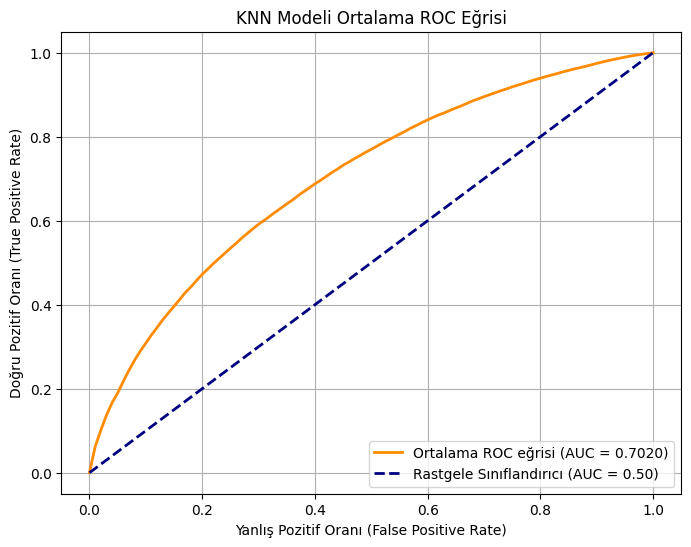

--------------------------------------------------


In [16]:
# KNN Modeli Ortalama ROC Eğrisi
# Bu hücre, KNN modelinin tüm dış katmanlarındaki (fold'larındaki) ROC eğrilerinin ortalamasını alır
# ve ortalama ROC eğrisini AUC skoru ile birlikte görselleştirir.
# Bu hücreyi çalıştırmadan önce, KNN modeli (Hücre 6.1) ve Nested CV ayarlarının (Hücre 4)
# çalıştırıldığından emin olun, çünkü bu hücre global 'roc_curves' ve 'results' değişkenlerini kullanır.

print("\n--- KNN Modeli Ortalama ROC Eğrisi ---")

model_name = 'KNN' # Hangi modelin ROC eğrisini çizmek istediğimizi belirtiyoruz

# KNN modeline ait tüm fold'lardaki FPR ve TPR verilerini topla
fold_fprs = []
fold_tprs = []
# 'roc_curves' global değişkeninin mevcut ve içinde 'KNN' anahtarının olup olmadığını kontrol et
if 'roc_curves' in globals() and f'{model_name}_Fold_1' in roc_curves: # İlk fold'un da varlığını kontrol edelim.
    for key, value in roc_curves.items():
        if key.startswith(f'{model_name}_Fold_'):
            fold_fprs.append(value['fpr'])
            fold_tprs.append(value['tpr'])

# Ortalama ROC AUC skorunu global sonuçlardan al
avg_roc_auc = None
# 'results' global değişkeninin mevcut olup olmadığını kontrol et
if 'results' in globals():
    for res in results:
        if res['Model'] == model_name:
            avg_roc_auc = res['Avg_ROC_AUC']
            break

# Ortalama ROC eğrisini hesapla ve çiz
if fold_fprs and fold_tprs and avg_roc_auc is not None:
    base_fpr = np.linspace(0, 1, 101) # 0'dan 1'e kadar eşit aralıklı 101 nokta
    tprs_interp = []
    for i in range(len(fold_fprs)):
        # Her fold'un TPR değerlerini ortak FPR noktalarına göre interpole et
        tprs_interp.append(np.interp(base_fpr, fold_fprs[i], fold_tprs[i]))
    
    mean_tpr = np.mean(tprs_interp, axis=0) # İnterpole edilmiş TPR'lerin ortalamasını al
    mean_tpr[0] = 0.0 # Eğrinin (0,0) noktasından başlamasını sağla
    mean_tpr[-1] = 1.0 # Eğrinin (1,1) noktasına ulaşmasını sağla

    plt.figure(figsize=(8, 6))
    plt.plot(base_fpr, mean_tpr, color='darkorange', lw=2, 
             label=f'Ortalama ROC eğrisi (AUC = {avg_roc_auc:.4f})') # Ortalama AUC skorunu etikete ekle
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Rastgele Sınıflandırıcı (AUC = 0.50)')
    plt.xlabel('Yanlış Pozitif Oranı (False Positive Rate)')
    plt.ylabel('Doğru Pozitif Oranı (True Positive Rate)')
    plt.title(f'{model_name} Modeli Ortalama ROC Eğrisi')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    print(f"  {model_name} modeli için ROC eğrisi verisi bulunamadı.")
    print("  Lütfen aşağıdaki hücreleri sırasıyla çalıştırdığınızdan emin olun:")
    print("  1. Hücre 1: Gerekli Kütüphaneler ve Genel Ayarlar")
    print("  2. Hücre 2: Veri Yükleme ve İlk İnceleme")
    print("  3. Hücre 3: Aykırı Değer (Outlier) ve Eksik Değer (Missing Value) Kontrolü")
    print("  4. Hücre 4: Veri Normalizasyonu ve Çapraz Doğrulama Ayarları")
    print("  5. Hücre 5.5: Global Sonuç Değişkenlerinin Tanımlanması")
    print("  6. Hücre 6.1: KNN Model Eğitimi ve Değerlendirmesi")

print("-" * 50)



--- SVM Modeli Ortalama ROC Eğrisi ---


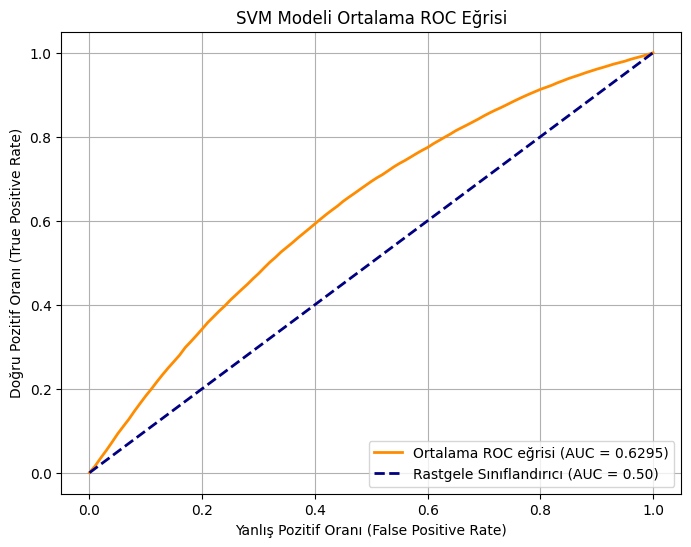

--------------------------------------------------


In [17]:
# SVM Modeli Ortalama ROC Eğrisi
# Bu hücre, SVM modelinin tüm dış katmanlarındaki (fold'larındaki) ROC eğrilerinin ortalamasını alır
# ve ortalama ROC eğrisini AUC skoru ile birlikte görselleştirir.
# Bu hücreyi çalıştırmadan önce, SVM modeli (Hücre 6.2) ve Nested CV ayarlarının (Hücre 4)
# çalıştırıldığından emin olun, çünkü bu hücre global 'roc_curves' ve 'results' değişkenlerini kullanır.

print("\n--- SVM Modeli Ortalama ROC Eğrisi ---")

model_name = 'SVM' # Hangi modelin ROC eğrisini çizmek istediğimizi belirtiyoruz

# SVM modeline ait tüm fold'lardaki FPR ve TPR verilerini topla
fold_fprs = []
fold_tprs = []
# 'roc_curves' global değişkeninin mevcut ve içinde 'SVM' anahtarının olup olmadığını kontrol et
if 'roc_curves' in globals() and f'{model_name}_Fold_1' in roc_curves: # İlk fold'un da varlığını kontrol edelim.
    for key, value in roc_curves.items():
        if key.startswith(f'{model_name}_Fold_'):
            fold_fprs.append(value['fpr'])
            fold_tprs.append(value['tpr'])

# Ortalama ROC AUC skorunu global sonuçlardan al
avg_roc_auc = None
# 'results' global değişkeninin mevcut olup olmadığını kontrol et
if 'results' in globals():
    for res in results:
        if res['Model'] == model_name:
            avg_roc_auc = res['Avg_ROC_AUC']
            break

# Ortalama ROC eğrisini hesapla ve çiz
if fold_fprs and fold_tprs and avg_roc_auc is not None:
    base_fpr = np.linspace(0, 1, 101) # 0'dan 1'e kadar eşit aralıklı 101 nokta
    tprs_interp = []
    for i in range(len(fold_fprs)):
        # Her fold'un TPR değerlerini ortak FPR noktalarına göre interpole et
        tprs_interp.append(np.interp(base_fpr, fold_fprs[i], fold_tprs[i]))
    
    mean_tpr = np.mean(tprs_interp, axis=0) # İnterpole edilmiş TPR'lerin ortalamasını al
    mean_tpr[0] = 0.0 # Eğrinin (0,0) noktasından başlamasını sağla
    mean_tpr[-1] = 1.0 # Eğrinin (1,1) noktasına ulaşmasını sağla

    plt.figure(figsize=(8, 6))
    plt.plot(base_fpr, mean_tpr, color='darkorange', lw=2, 
             label=f'Ortalama ROC eğrisi (AUC = {avg_roc_auc:.4f})') # Ortalama AUC skorunu etikete ekle
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Rastgele Sınıflandırıcı (AUC = 0.50)')
    plt.xlabel('Yanlış Pozitif Oranı (False Positive Rate)')
    plt.ylabel('Doğru Pozitif Oranı (True Positive Rate)')
    plt.title(f'{model_name} Modeli Ortalama ROC Eğrisi')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    print(f"  {model_name} modeli için ROC eğrisi verisi bulunamadı.")
    print("  Lütfen aşağıdaki hücreleri sırasıyla çalıştırdığınızdan emin olun:")
    print("  1. Hücre 1: Gerekli Kütüphaneler ve Genel Ayarlar")
    print("  2. Hücre 2: Veri Yükleme ve İlk İnceleme")
    print("  3. Hücre 3: Aykırı Değer (Outlier) ve Eksik Değer (Missing Value) Kontrolü")
    print("  4. Hücre 4: Veri Normalizasyonu ve Çapraz Doğrulama Ayarları")
    print("  5. Hücre 5.5: Global Sonuç Değişkenlerinin Tanımlanması")
    print("  6. Hücre 6.2: SVM Model Eğitimi ve Değerlendirmesi")

print("-" * 50)



--- MLP Modeli Ortalama ROC Eğrisi ---


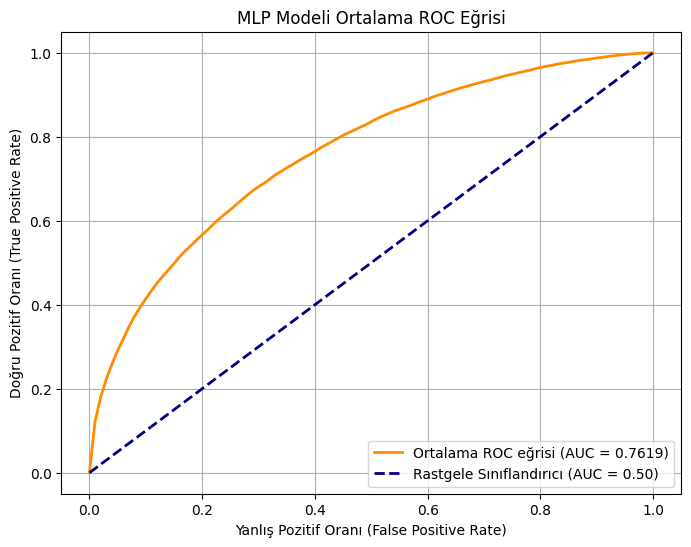

--------------------------------------------------


In [18]:
# MLP Modeli Ortalama ROC Eğrisi
# Bu hücre, MLP modelinin tüm dış katmanlarındaki (fold'larındaki) ROC eğrilerinin ortalamasını alır
# ve ortalama ROC eğrisini AUC skoru ile birlikte görselleştirir.
# Bu hücreyi çalıştırmadan önce, MLP modeli (Hücre 6.3) ve Nested CV ayarlarının (Hücre 4)
# çalıştırıldığından emin olun, çünkü bu hücre global 'roc_curves' ve 'results' değişkenlerini kullanır.

print("\n--- MLP Modeli Ortalama ROC Eğrisi ---")

model_name = 'MLP' # Hangi modelin ROC eğrisini çizmek istediğimizi belirtiyoruz

# MLP modeline ait tüm fold'lardaki FPR ve TPR verilerini topla
fold_fprs = []
fold_tprs = []
# 'roc_curves' global değişkeninin mevcut ve içinde 'MLP' anahtarının olup olmadığını kontrol et
if 'roc_curves' in globals() and f'{model_name}_Fold_1' in roc_curves: # İlk fold'un da varlığını kontrol edelim.
    for key, value in roc_curves.items():
        if key.startswith(f'{model_name}_Fold_'):
            fold_fprs.append(value['fpr'])
            fold_tprs.append(value['tpr'])

# Ortalama ROC AUC skorunu global sonuçlardan al
avg_roc_auc = None
# 'results' global değişkeninin mevcut olup olmadığını kontrol et
if 'results' in globals():
    for res in results:
        if res['Model'] == model_name:
            avg_roc_auc = res['Avg_ROC_AUC']
            break

# Ortalama ROC eğrisini hesapla ve çiz
if fold_fprs and fold_tprs and avg_roc_auc is not None:
    base_fpr = np.linspace(0, 1, 101) # 0'dan 1'e kadar eşit aralıklı 101 nokta
    tprs_interp = []
    for i in range(len(fold_fprs)):
        # Her fold'un TPR değerlerini ortak FPR noktalarına göre interpole et
        tprs_interp.append(np.interp(base_fpr, fold_fprs[i], fold_tprs[i]))
    
    mean_tpr = np.mean(tprs_interp, axis=0) # İnterpole edilmiş TPR'lerin ortalamasını al
    mean_tpr[0] = 0.0 # Eğrinin (0,0) noktasından başlamasını sağla
    mean_tpr[-1] = 1.0 # Eğrinin (1,1) noktasına ulaşmasını sağla

    plt.figure(figsize=(8, 6))
    plt.plot(base_fpr, mean_tpr, color='darkorange', lw=2, 
             label=f'Ortalama ROC eğrisi (AUC = {avg_roc_auc:.4f})') # Ortalama AUC skorunu etikete ekle
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Rastgele Sınıflandırıcı (AUC = 0.50)')
    plt.xlabel('Yanlış Pozitif Oranı (False Positive Rate)')
    plt.ylabel('Doğru Pozitif Oranı (True Positive Rate)')
    plt.title(f'{model_name} Modeli Ortalama ROC Eğrisi')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    print(f"  {model_name} modeli için ROC eğrisi verisi bulunamadı.")
    print("  Lütfen aşağıdaki hücreleri sırasıyla çalıştırdığınızdan emin olun:")
    print("  1. Hücre 1: Gerekli Kütüphaneler ve Genel Ayarlar")
    print("  2. Hücre 2: Veri Yükleme ve İlk İnceleme")
    print("  3. Hücre 3: Aykırı Değer (Outlier) ve Eksik Değer (Missing Value) Kontrolü")
    print("  4. Hücre 4: Veri Normalizasyonu ve Çapraz Doğrulama Ayarları")
    print("  5. Hücre 5.5: Global Sonuç Değişkenlerinin Tanımlanması")
    print("  6. Hücre 6.3: MLP Model Eğitimi ve Değerlendirmesi")

print("-" * 50)



--- XGBoost Modeli Ortalama ROC Eğrisi ---


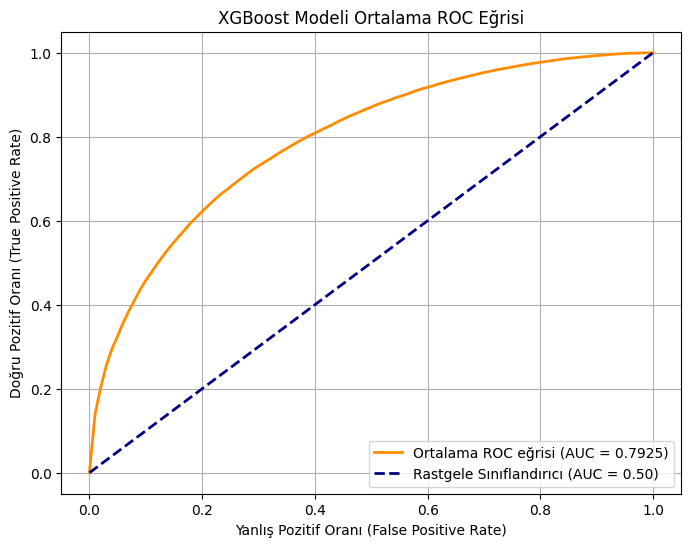

--------------------------------------------------


In [19]:
# XGBoost Modeli Ortalama ROC Eğrisi
# Bu hücre, XGBoost modelinin tüm dış katmanlarındaki (fold'larındaki) ROC eğrilerinin ortalamasını alır
# ve ortalama ROC eğrisini AUC skoru ile birlikte görselleştirir.
# Bu hücreyi çalıştırmadan önce, XGBoost modeli (Hücre 6.4) ve Nested CV ayarlarının (Hücre 4)
# çalıştırıldığından emin olun, çünkü bu hücre global 'roc_curves' ve 'results' değişkenlerini kullanır.

print("\n--- XGBoost Modeli Ortalama ROC Eğrisi ---")

model_name = 'XGBoost' # Hangi modelin ROC eğrisini çizmek istediğimizi belirtiyoruz

# XGBoost modeline ait tüm fold'lardaki FPR ve TPR verilerini topla
fold_fprs = []
fold_tprs = []
# 'roc_curves' global değişkeninin mevcut ve içinde 'XGBoost' anahtarının olup olmadığını kontrol et
if 'roc_curves' in globals() and f'{model_name}_Fold_1' in roc_curves: # İlk fold'un da varlığını kontrol edelim.
    for key, value in roc_curves.items():
        if key.startswith(f'{model_name}_Fold_'):
            fold_fprs.append(value['fpr'])
            fold_tprs.append(value['tpr'])

# Ortalama ROC AUC skorunu global sonuçlardan al
avg_roc_auc = None
# 'results' global değişkeninin mevcut olup olmadığını kontrol et
if 'results' in globals():
    for res in results:
        if res['Model'] == model_name:
            avg_roc_auc = res['Avg_ROC_AUC']
            break

# Ortalama ROC eğrisini hesapla ve çiz
if fold_fprs and fold_tprs and avg_roc_auc is not None:
    base_fpr = np.linspace(0, 1, 101) # 0'dan 1'e kadar eşit aralıklı 101 nokta
    tprs_interp = []
    for i in range(len(fold_fprs)):
        # Her fold'un TPR değerlerini ortak FPR noktalarına göre interpole et
        tprs_interp.append(np.interp(base_fpr, fold_fprs[i], fold_tprs[i]))
    
    mean_tpr = np.mean(tprs_interp, axis=0) # İnterpole edilmiş TPR'lerin ortalamasını al
    mean_tpr[0] = 0.0
    mean_tpr[-1] = 1.0 # Ensure the curve goes to (1,1)

    plt.figure(figsize=(8, 6))
    plt.plot(base_fpr, mean_tpr, color='darkorange', lw=2, 
             label=f'Ortalama ROC eğrisi (AUC = {avg_roc_auc:.4f})') # Ortalama AUC skorunu etikete ekle
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Rastgele Sınıflandırıcı (AUC = 0.50)')
    plt.xlabel('Yanlış Pozitif Oranı (False Positive Rate)')
    plt.ylabel('Doğru Pozitif Oranı (True Positive Rate)')
    plt.title(f'{model_name} Modeli Ortalama ROC Eğrisi')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
else:
    print(f"  {model_name} modeli için ROC eğrisi verisi bulunamadı.")
    print("  Lütfen aşağıdaki hücreleri sırasıyla çalıştırdığınızdan emin olun:")
    print("  1. Hücre 1: Gerekli Kütüphaneler ve Genel Ayarlar")
    print("  2. Hücre 2: Veri Yükleme ve İlk İnceleme")
    print("  3. Hücre 3: Aykırı Değer (Outlier) ve Eksik Değer (Missing Value) Kontrolü")
    print("  4. Hücre 4: Veri Normalizasyonu ve Çapraz Doğrulama Ayarları")
    print("  5. Hücre 5.5: Global Sonuç Değişkenlerinin Tanımlanması")
    print("  6. Hücre 6.4: XGBoost Model Eğitimi ve Değerlendirmesi")

print("-" * 50)
